# Detrending Light Curve Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import exoplanet as xo
from scipy.interpolate import interp1d
from matplotlib.widgets import Slider, Button


print(f"exoplanet.__version__ = '{xo.__version__}'")

exoplanet.__version__ = '0.5.1'


In [2]:
def tic_id_from_simbad(other_id):
    #takes other_id (string) and queries Simbad to obtain the TIC ID
    
    from astroquery.simbad import Simbad
    import astropy
    ID_table = Simbad.query_objectids(other_id)
    
    if type(ID_table) is not astropy.table.table.Table:
        return(None)
    
    ID_table['ID'] = ID_table['ID'].astype(str)
    

    ID_pandas = ID_table.to_pandas()
    tic_id = ID_pandas[ID_pandas['ID'].str.contains("TIC")]
    
    
    return tic_id['ID'].values[0]

In [3]:
def transit_info_from_exoplanet_archive(tic_id):
    #takes TIC ID and queries exoplanet archive to return t0, period, and duration
    
    import pyvo as vo
    import pandas as pd


    service = vo.dal.TAPService("https://exoplanetarchive.ipac.caltech.edu/TAP")
    
    a = service.search("SELECT \
                       tic_id, pl_tranmid, pl_orbper, pl_trandur\
                       FROM pscomppars")
    
   
    
    exoplanets = a.to_table()
    
    exoplanets = exoplanets.to_pandas()
    
    
    #rename columns
    column_dict = {
    'pl_tranmid':'t0 [BJD]',
    'pl_orbper':'period [days]',
    'pl_trandur':'duration [hours]',
    }
    
    exoplanets.rename(columns=column_dict, inplace=True)
    
    result = exoplanets[exoplanets['tic_id'] == tic_id]
    print(result)

    #if there's no row in the planetary comparison table, check TOI table
    if result.empty:
        print("Exoplanet Archive: TOI Table")
        print("----------------------------")
        print("")
        a = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=toi&select=tid,pl_tranmid,pl_orbper,pl_trandurh&format=csv"

        exoplanets = pd.read_csv(a)
        
        #rename columns
        column_dict = {
        'tid':'tic_id',
        'pl_tranmid':'t0 [BJD]',
        'pl_orbper':'period [days]',
        'pl_trandurh':'duration [hours]',
        }
        
        exoplanets.rename(columns=column_dict, inplace=True)
        exoplanets['tic_id'] = 'TIC ' + exoplanets['tic_id'].astype(str)
        
        result = exoplanets[exoplanets['tic_id'] == tic_id]
        
        
    else:
        print("Exoplanet Archive: Planet Comparison Table")
        print("------------------------------------------")
        print("")
        
    

    return result
    
    



In [4]:
def get_transit_info(planet_id):
    #takes a id, queries Simbad to get matching TIC ID
    #then queries exoplanet archive to extract t0, period, and duration
    #if no Simbad match found, then returns None and prints error message
    #if no exoplanet archive match found, then returns None and prints error message

    tic_id = tic_id_from_simbad(planet_id)
    

    if tic_id != None:
        transit_info = transit_info_from_exoplanet_archive(tic_id)
        
        if transit_info.empty:
            print("No TIC ID match found on exoplanet archive")
            return None
        
        else:
            return transit_info
            
    else:
        print("No TIC ID match found on Simbad")
        return None

In [5]:
def find_nearest(array, value):
    #returns the value in an array closest to another input value
    
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [6]:
def get_light_curve(planet_id, flux_type, TESS = False, Kepler = False, 
                    user_periods = None, user_t0s = None, user_durations = None):
    import math
    import numpy as np
    import lightkurve as lk
    from astropy.io import fits

    transit_info = get_transit_info(planet_id)
    if type(transit_info) == None:
        return None
    
    print(transit_info)
    
    tic_id = str(transit_info['tic_id'].values[0])
    
    
    if user_periods != None:
        periods = user_periods
        print("using periods = " + str(user_periods))
    else:
        periods = np.array(transit_info['period [days]'].values, dtype = float)

        
    if user_t0s != None:
        t0s = user_t0s
        print("using t0s = " + str(user_t0s))
    else:
        t0s = np.array(transit_info['t0 [BJD]'].values, dtype = float)

    if user_durations != None:
        durations = user_durations
        print("using durations = " + str(user_durations))
    else:
        durations = np.array(transit_info['duration [hours]'].values, dtype = float)
    
    
    
    nplanets = len(periods)
    
    if TESS:
        #switch to TESS BJD
        t0s = t0s - 2457000
        
        #pull in TESS SPOC LC
        lc_files = lk.search_lightcurve(
            tic_id, mission='TESS', author = 'SPOC'
        ).download_all(quality_bitmask="hardest", flux_column=flux_type)
        
        
        
    if Kepler:
        #switch to Kepler BJD
        t0s = t0s - 2454833
        
        #pull in Kepler LC
        lc_files = lk.search_lightcurve(
            tic_id, mission='Kepler'
        ).download_all(quality_bitmask="hardest", flux_column=flux_type)
        
    
    quarters = []
    crowding = []
    flux_fraction = []
    for file in lc_files:
        quarters.append([np.min(file.time.value),
                        np.max(file.time.value)])
        
        crowding.append(file.CROWDSAP)
        flux_fraction.append(file.FLFRCSAP)
        
        
    
        
    lc = lc_files.stitch().remove_nans()
    
    xs = lc.time.value
    ys = lc.flux
    ys_err = lc.flux_err
    

   

    mask = np.zeros(np.shape(xs), dtype=bool)
    for ii in range(0, nplanets):
        masks = lc.create_transit_mask(period=periods[ii], duration=durations[ii]/24.*1.3, transit_time=t0s[ii])
        mask += masks
        
    
    
    min_time = xs.min()
    max_time = xs.max()

    
    t0s_all = []
    for ii in range(0, nplanets):
        t0 = t0s[ii]
        period = periods[ii]
        while t0 > min_time:
            t0 -= period

        
        while t0 < max_time:
            t0s_all.append(t0)
            t0 += period
    
    
    t0s_in_data = []
    for t0 in t0s_all:
        nearest_lc_time = find_nearest(xs, t0)
        if np.abs(t0 - nearest_lc_time) < 0.1: # 2.5 hours ~ 0.1 days
            t0s_in_data.append(t0)
            
            
    mu = np.median( ys )
    ys = ( ys / mu - 1 )
    ys_err = ( ys_err / mu )
    
    

    
    

    
    return \
        np.array(xs), np.array(ys), np.array(ys_err), mask, \
        np.array(t0s_in_data), periods, durations, quarters, crowding, flux_fraction
    
    



In [69]:
#pulls in light curve
sap_time, sap_lc, sap_lc_err, sap_mask, \
t0s, period, duration, quarters, crowding, flux_fraction  = \
get_light_curve_multi('toi-1130', 'sap_flux', TESS=True, planet_number = 2, mask_width = 1.8)
                #user_periods = np.array([period]),
                #user_t0s = np.array([t0]),
                #user_durations = np.array([duration]))

             tic_id      t0 [BJD]  period [days]  duration [hours]
361   TIC 254113311  2.458659e+06       4.066499              2.30
3218  TIC 254113311  2.458658e+06       8.350381              2.02
Exoplanet Archive: Planet Comparison Table
------------------------------------------

             tic_id      t0 [BJD]  period [days]  duration [hours]
361   TIC 254113311  2.458659e+06       4.066499              2.30
3218  TIC 254113311  2.458658e+06       8.350381              2.02
here
LightCurveCollection of 1 objects:
    0: <TessLightCurve LABEL="TIC 254113311" SECTOR=27 AUTHOR=SPOC FLUX_ORIGIN=sap_flux>
good


/Users/Danielyahalomi/anaconda3/envs/py39/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


In [72]:
print(type(period))

<class 'numpy.ndarray'>


In [80]:
def get_light_curve_multi(planet_id, flux_type, TESS = False, Kepler = False, 
                          user_periods = None, user_t0s = None, user_durations = None,
                          planet_number = 1, mask_width = 1.3):
    
    import math
    import numpy as np
    import lightkurve as lk
    from astropy.io import fits

    transit_info = get_transit_info(planet_id)
    if type(transit_info) == None:
        return None
    
    print(transit_info)
    
    tic_id = str(transit_info['tic_id'].values[0])
    
    
    if user_periods != None:
        periods = user_periods
        print("using periods = " + str(user_periods))
    else:
        periods = np.array(transit_info['period [days]'].values, dtype = float)

        
    if user_t0s != None:
        t0s = user_t0s
        print("using t0s = " + str(user_t0s))
    else:
        t0s = np.array(transit_info['t0 [BJD]'].values, dtype = float)

    if user_durations != None:
        durations = user_durations
        print("using durations = " + str(user_durations))
    else:
        durations = np.array(transit_info['duration [hours]'].values, dtype = float)
    
    
    
    nplanets = len(periods)
    
    if TESS:
        #switch to TESS BJD
        t0s = t0s - 2457000
        
        #pull in short cadence TESS SPOC LC
        lc_files_short_cadence = lk.search_lightcurve(
            tic_id, mission='TESS', author = 'SPOC', cadence = 'short'
        ).download_all(quality_bitmask="hardest", flux_column=flux_type)
        
        #pull in long cadence TESS SPOC LC
        lc_files_long_cadence = lk.search_lightcurve(
            tic_id, mission='TESS', author = 'SPOC', cadence = 'long'
        ).download_all(quality_bitmask="hardest", flux_column=flux_type)
        
        
        #use short cadence TESS data if if exists, else use long cadence
        print('here')
        print(lc_files_short_cadence)
        if lc_files_short_cadence == []:
            print('bad')
            lc_files = lc_files_long_cadence
        else:
            print('good')
            lc_files = lc_files_short_cadence
        
    if Kepler:
        #switch to Kepler BJD
        t0s = t0s - 2454833
        
        #pull in Kepler LC
        lc_files = lk.search_lightcurve(
            tic_id, mission='Kepler'
        ).download_all(quality_bitmask="hardest", flux_column=flux_type)
        
    
    quarters = []
    crowding = []
    flux_fraction = []
    for file in lc_files:
        quarters.append([np.min(file.time.value),
                        np.max(file.time.value)])
        
        crowding.append(file.CROWDSAP)
        flux_fraction.append(file.FLFRCSAP)
        
        
    
        
    lc = lc_files.stitch().remove_nans()
    
    xs = lc.time.value
    ys = lc.flux
    ys_err = lc.flux_err
    

   

    mask = np.zeros(np.shape(xs), dtype=bool)
    for ii in range(0, nplanets):
        masks = lc.create_transit_mask(period=periods[ii], 
                                       duration=durations[ii]/24.*mask_width, 
                                       transit_time=t0s[ii])
        mask += masks
        
    mask_fitted_planet = lc.create_transit_mask(period=periods[planet_number-1], 
                                                duration=durations[planet_number-1]/24.*mask_width, 
                                                transit_time=t0s[planet_number-1])

    
        
    
    
    
    
    
    #save the period, duration, and t0 for the planet we are fitting for...
    period = np.array([periods[planet_number-1]])
    t0 = t0s[planet_number-1]
    duration = np.array([durations[planet_number-1]])
    
    
    min_time = xs.min()
    max_time = xs.max()
    t0s_all = []
    while t0 > min_time:
        t0 -= period[0]

    while t0 < max_time:
        t0s_all.append(t0)
        t0 += period[0]
    
    
    t0s_in_data = []
    for t0 in t0s_all:
        nearest_lc_time = find_nearest(xs, t0)
        if np.abs(t0 - nearest_lc_time) < 0.1: # 2.5 hours ~ 0.1 days
            t0s_in_data.append(t0)
            
            
    mu = np.median( ys )
    ys = ( ys / mu - 1 )
    ys_err = ( ys_err / mu )
    
    

    
    

    
    return \
        np.array(xs), np.array(ys), np.array(ys_err), mask, mask_fitted_planet, \
        np.array(t0s_in_data), period, duration, quarters, crowding, flux_fraction
    
    



In [81]:
def reject_outliers_out_of_transit(time, flux, flux_err, mask, mask_fitted_planet, time_window, sigma_window):
    '''
    rejects outliers via moving median and sigma clipping outside of transit mask
    
    input:
    time = array of time values
    flux = array of flux values
    flux_err = array of flux error values
    mask = array of all mask values
    mask = array of mask values only for the planet we are fitting 
    time_window = int, how much time around which to determine median on
    sigma_window = int, how many sigmas to clip
    
    
    returns:
    flux_out = array of flux values with outliers value changed to np.nan 
    flux_err_out = array of flux error values with outliers value changed to np.nan  
    
    '''
    
    if len(time) != len(flux):
        print('error, mismatched time and flux data length')
        
        

    
    #find the time right before and after data gaps, this is used to only do outlier rejection after 1 full time_window
    #data gap is considered anything greater than 1 time window wide
    time_gap_adjacent = [time[0]]
    for ii in range(1, len(time)):
        if time[ii] - time[ii-1] > time_window:
            time_gap_adjacent.append(time[ii])
            time_gap_adjacent.append(time[ii-1])
            
            
    #also add in right before and after transits to time_gap_adjacent
    for ii in range(1, len(time)):
        if mask[ii] and not mask[ii-1]:
            time_gap_adjacent.append(time[ii-1])
        if not mask[ii] and mask[ii-1]:
            time_gap_adjacent.append(time[ii])
            
    
    
                    
                    
                    
    time_out = []
    flux_out = []
    flux_err_out = []
    mask_out = []
    mask_fitted_planet_out = []
    moving_median = []
    for ii in range(0, len(time)):
        current_time = time[ii]
        current_flux = flux[ii]
        current_flux_err = flux_err[ii]
        current_mask = mask[ii]
        current_mask_fitted_planet = mask_fitted_planet[ii]
        
        #find indices that we want to include in the moving median
        #include if greater than minimum window value
        #and smaller than maximum window value
        #and not during a transit
        indices = np.where(np.logical_and(np.logical_and(time>=current_time-time_window/2., time<=current_time+time_window/2.), ~mask))
        current_flux_median = np.median(flux[indices])
        
        
        #only do outlier rejection outside of transits
        if not current_mask:
            
            #only do outlier rejection if not within 1 time window of a data gap or transit
            near_time_gaps = False
            for time_gap in time_gap_adjacent:
                if np.abs(current_time - time_gap) < time_window:
                    near_time_gaps = True
                    
            if not near_time_gaps:
                if current_flux+sigma_window*current_flux_err >= current_flux_median and current_flux-sigma_window*current_flux_err <= current_flux_median:
                    time_out.append(current_time)
                    flux_out.append(current_flux)
                    flux_err_out.append(current_flux_err)
                    mask_out.append(current_mask)
                    mask_fitted_planet_out.append(current_mask_fitted_planet)
                    moving_median.append(current_flux_median)

                else:
                    moving_median.append(current_flux_median)
                    
            
            else:
                time_out.append(current_time)
                flux_out.append(current_flux)
                flux_err_out.append(current_flux_err)
                mask_out.append(current_mask)
                mask_fitted_planet_out.append(current_mask_fitted_planet)
                moving_median.append(np.nan)
                
        else:
            time_out.append(current_time)
            flux_out.append(current_flux)
            flux_err_out.append(current_flux_err)
            mask_out.append(current_mask)
            mask_fitted_planet_out.append(current_mask_fitted_planet)
            moving_median.append(np.nan)

    
    time_out = np.array(time_out)
    flux_out = np.array(flux_out)
    flux_err_out = np.array(flux_err_out)
    mask_out = np.array(mask_out)
    mask_fitted_planet_out = np.array(mask_fitted_planet_out)
            
    
    return time_out, flux_out, flux_err_out, mask_out, mask_fitted_planet_out, moving_median

        

In [9]:
def plot_outliers(time, flux, time_out, flux_out, moving_median, kepler_quarters):
    '''
    input:
    -------
    time = array of time values 
    flux = array of flux values 
    time_out = array of time values without outliers
    flux_out = array of flux values without outliers
    '''
    
    
    outlier_times = []
    outlier_fluxes = []
    n_outliers = len(flux)-len(flux_out)
    
    
    outliers_count=0
    for ii in range(0, len(time)):
        if time[ii] not in time_out:
            outliers_count+=1
            outlier_times.append(time[ii])
            outlier_fluxes.append(flux[ii])
            
    if outliers_count == n_outliers:
        print(str(n_outliers) + ' outliers')
        
    else:
        print("ERROR, didn't find all outliers")
            
    fig, ax = plt.subplots(1, 1, figsize = [18,9])


    ax.plot(time_out, flux_out, 'o', color = 'grey', alpha = 0.7)
    ax.plot(outlier_times, outlier_fluxes, 'o', color = 'red', alpha = 1.0)
    #ax.plot(time, moving_median, '.', color = 'k')
    [ax.axvline(_x, linewidth=1, color='k', ls='--') for _x in kepler_quarters]

    ax.set_xlabel("time [days]")
    ax.set_ylabel("intensity")

        
    fig.tight_layout()
    
    return None

In [10]:
def plot_individual_lc(xs_star, ys_star, xs_transit, ys_transit, t0s_in_data, window, period, problem_times):
    #xs_star = time not in transit
    #ys_star = flux not in transit
    #xs_transit = times in transit
    #ys_tranist = fluxed in transit
    #t0s_in_data = midtransits in data
    #window = what fraction of the period to plot on either side of transit (ie. window=1/2 means 1/2 period on either side)
    #period = planet period to define plotting limit
    
    fig, ax = plt.subplots(nrows = len(t0s_in_data), figsize = [9,3*len(t0s_in_data)])
    plt.subplots_adjust(left=0.2, bottom=0.1, hspace = 0.3)

    problem_times = []

    t_init = 0

    ts=[]
    ys=[]
    ls=[]
    if len(t0s_in_data) > 1:
        for ii in range(0, len(t0s_in_data)):

            y=np.arange(-.01, .01, 0.00001)
            ys.append(y)
            
            t = t_init*np.ones(np.shape(y))
            ts.append(t)
            
            ls.append(ax[ii].plot(t, y, lw=2, color='red')[0])
            
            t0 = t0s_in_data[ii]
            ax[ii].plot(xs_star, ys_star, '.', color = 'grey', alpha = 0.5)
            ax[ii].plot(xs_transit, ys_transit, '.', color = 'k', alpha = 0.5)
            [ax[ii].axvline(_x, linewidth=1, color='k') for _x in t0s_in_data]
            [ax[ii].axvline(_x, linewidth=1, color='r') for _x in problem_times]
            ax[ii].set_xlabel("time [days]")
            ax[ii].set_ylabel("intensity")
            ax[ii].set_xlim(t0-(period*window), t0+(period*window))
    
    else:
        y=np.arange(-.01, .01, 0.00001)
        ys.append(y)

        t = t_init*np.ones(np.shape(y))
        ts.append(t)

        ls.append(ax[ii].plot(t, y, lw=2, color='red')[0])
            
        t0 = t0s_in_data[0]
        ax.plot(xs_star, ys_star, '.', color = 'grey')
        ax.plot(xs_transit, ys_transit, '.', color = 'k')
        [ax.axvline(_x, linewidth=1, color='k') for _x in t0s_in_data]
        [ax[ii].axvline(_x, linewidth=1, color='r') for _x in problem_times]
        ax.set_xlabel("time [days]")
        ax.set_ylabel("intensity")
        ax.set_xlim(t0-(period*window), t0+(period*window))
        
        

    axtime = plt.axes([0.1, 0.1, 0.036, 0.779])
    stime = Slider(axtime, 'time', np.min(xs_star), np.max(xs_star), valinit=t_init, orientation="vertical")

    def update(val):
        for ii in range(0, transits):
            ls[ii].set_xdata(val*np.ones(np.shape(ys[ii])))


        fig.canvas.draw_idle()

    stime.on_changed(update)

    resetax = plt.axes([0.8, 0.025, 0.13, 0.04])
    button = Button(resetax, 'save time', color='0.97', hovercolor='0.79')

    def save(event):
        if stime.val not in problem_times:
            problem_times.append(stime.val)


    button.on_clicked(save)

        
    
    return fig

In [11]:
def plot_transit(xs_star, ys_star, xs_transit, ys_transit, t0, period, title, problem_times_input=None):
    #xs_star = time not in transit
    #ys_star = flux not in transit
    #xs_transit = times in transit
    #ys_tranist = fluxed in transit
    #t0 = midtransit
    #period = planet period to define plotting limit
    
    global problem_times
    
    if problem_times_input == None:
        problem_times = []
        
    else:
        problem_times_input.sort()
        problem_times = problem_times_input
        
        
    window = 1./2.
    
    fig, ax = plt.subplots(1,1, figsize = [9,6])
    plt.subplots_adjust(left=0.2, bottom=0.3, hspace = 0.3)
    
    for 

    t_init = 0

    y = np.arange(-.03, .03, 0.000001)

    t = t_init*np.ones(np.shape(y))

    l = ax.plot(t, y, lw=2, color='red')[0]


    xmin, xmax = t0-(period*window)[0], t0+(period*window)[0]
    ymin, ymax = 1.2*np.nanmin(ys_star), 1.2*np.nanmax(ys_star)
    
    ax.plot(xs_star, ys_star, '.', color = 'grey', alpha = 0.7)
    ax.plot(xs_transit, ys_transit, '.', color = 'black', alpha = 0.7)
    ax.text(xmin+(xmax-xmin)*.05, 0, title, fontsize = 27)

    ax.axvline(t0, linewidth=1, color='k')
    ax.set_xlabel("time [days]")
    ax.set_ylabel("intensity")
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)


    axtime = plt.axes([0.197, 0.1, 0.702, 0.09])
    stime = Slider(axtime, 'time', xmin, xmax, valinit=t_init, orientation="horizontal")

    def update(val):
        l.set_xdata(val*np.ones(np.shape(y)))

        fig.canvas.draw_idle()

    stime.on_changed(update)

    save_time = plt.axes([0.8, 0.025, 0.13, 0.04])
    button = Button(save_time, 'save time', color='0.97', hovercolor='0.79')

    def save(event):
        global problem_times
        if stime.val not in problem_times:
            problem_times.append(stime.val)
            problem_times.sort()


    button.on_clicked(save)
    


    return(stime, button)



In [12]:
def plot_transits(x_transits, y_transits, mask_transits, t0s, period, problem_times_input=None):
    #xs = times
    #ys = fluxes
    #mask = masks for transit
    #t0s = midtransits in data
    #period = planet period to define plotting limits
    
    sliders, buttons = [], []
    
    if len(t0s) != len(x_transits):
        print("ERROR, length of t0s doesn't match length of x_transits")
    
    for ii in range(0, len(t0s)):
        t0 = t0s[ii]
        xs = x_transits[ii]
        ys = y_transits[ii]
        mask = mask_transits[ii]
        title = "epoch " + str(ii+1)
        
        slider, button = plot_transit(xs[~mask], ys[~mask], xs[mask], ys[mask], t0, period, title, problem_times_input)
        sliders.append(slider)
        buttons.append(button)
    
    return sliders, buttons


In [92]:
def trim_jump_times(x, y, yerr, mask, mask_fitted_planet, t0s, period, jump_times):
    #x = time 
    #y = flux 
    #yerr = flux error
    #mask = mask
    #t0s = midtransits
    #period = planet period to define plotting limit
    #jump_times = jump times to trim data around (one before and one after each transit)
    
   
    if jump_times != []:
        x_epochs = []
        y_epochs = []
        yerr_epochs = []
        mask_epochs = []
        mask_fitted_planet_epochs = []
    
        for ii in range(0, len(jump_times)-1):
            jump_start = jump_times[ii]
            jump_end = jump_times[ii+1]
            

            if ii % 2 == 0:
                jump_start = find_nearest(x, jump_start)
                jump_end = find_nearest(x, jump_end)
                

                epoch_split = [jump_start, jump_end]
                start_index = int(np.where(x == epoch_split[0])[0])
                end_index = int(np.where(x == epoch_split[1])[0])

                x_epochs.append(x[start_index:end_index])
                y_epochs.append(y[start_index:end_index])
                yerr_epochs.append(yerr[start_index:end_index])
                mask_epochs.append(mask[start_index:end_index])
                mask_fitted_planet_epochs.append(mask_fitted_planet[start_index:end_index])
                

        x_epochs = np.array(x_epochs, dtype=object)
        y_epochs = np.array(y_epochs, dtype=object)
        yerr_epochs = np.array(yerr_epochs, dtype=object)
        mask_epochs = np.array(mask_epochs, dtype=object)
        mask_fitted_planet_epochs = np.array(mask_fitted_planet_epochs, dtype=object)

    else:
        x_epochs, y_epochs, yerr_epochs, mask_epochs, mask_fitted_planet_epochs = \
        split_around_transits(x, y, yerr, mask, mask_fitted_planet, t0s, 1./2., period)
    


    
    return x_epochs, y_epochs, yerr_epochs, mask_epochs, mask_fitted_planet_epochs
        
        
    
        
    
    

In [166]:
def plot_detrended_lc(xs, ys, yerrs, detrend_labels, t0s_in_data, window, period, colors, duration, depth=None, figname=None):
    '''
    inputs:
    x = times
    ys = [detrended light curves] of length N number of detrendings
    detrend_labels = [detrending type] of length N number of detrendings
    t0s_in_data = midtransits in data
    window = what fraction of the period to plot on either side of transit (ie. window=1/2 means 1/2 period on either side)
    period = planet period to define plotting limit
    colors = [colors] of length N number of detrendings
    figname = Name of file if you want to save figure
    
    return:
    None
    
    
    
    
    
    '''
    import math    
        

            
    transit_windows = []
    for t0 in t0s_in_data:
        transit_windows.append([t0 - 1.3*duration/(2*24.), t0 + 1.3*duration/(2*24.)])

    
    n_transit = np.arange(0, len(t0s_in_data), 1)
    
    if len(ys) > 1:
        fig, ax = plt.subplots(ncols = 3, nrows = math.ceil(len(t0s_in_data)/3), figsize = [18,len(t0s_in_data)*len(ys)/2])
    else:
        fig, ax = plt.subplots(ncols = 3, nrows = math.ceil(len(t0s_in_data)/3), figsize = [18,len(t0s_in_data)*len(ys)])

    
    y_detrend = []
    
    
    if not depth:
        depth = 0.01
    
    if len(t0s_in_data) > 1:
        column = 0
        row = 0
        
        for ii in range(0, len(t0s_in_data)):
            if ii <= 3:
                ax_ii = ax[ii]#[column]
            else:
                ax_ii = ax[row][column]

            t0 = t0s_in_data[ii]
            
            
            detrend_offset = 0
            for detrend_index in range(0, len(ys)):
        
                x = xs
                y_detrend = ys[detrend_index]
                yerr = yerrs[detrend_index]
                
                
                ax_ii.errorbar(x, y_detrend + detrend_offset, yerr = yerr, ls='', marker='o', markersize=5, color = colors[detrend_index], alpha = 0.63)
                
                ax_ii.text(t0-(period*window)+.18, detrend_offset+.0018, 
                       detrend_labels[detrend_index], 
                       color=colors[detrend_index], fontsize=13)
                
                detrend_offset += depth
                
            ax_ii.axvline(transit_windows[ii][0], linewidth=1.8, color='k', alpha = 0.79, ls='--') 
            ax_ii.axvline(transit_windows[ii][1], linewidth=1.8, color='k', alpha = 0.79, ls='--')

            ax_ii.set_xlabel("time [days]")
            ax_ii.set_ylabel("intensity")
            ax_ii.set_xlim(t0-(period*window), t0+(period*window))
            ax_ii.set_ylim(-1.2*depth, depth*len(ys))
            ax_ii.tick_params(axis='x', rotation=45)
            

            if column == 2:
                column = 0
                row += 1
            else:
                column += 1


    else:
        t0 = t0s_in_data[0]
        detrend_offset = 0
        for detrend_index in range(0, len(ys)):

            x = xs
            y_detrend = ys[detrend_index]
            yerr = yerrs[detrend_index]

            ax.errorbar(x, y_detrend + detrend_offset, yerr=yerr, ls='', marker='o', markersize=5, color = colors[detrend_index], alpha = 0.63)

            detrend_offset += depth

        [ax.axvline(transit[0], linewidth=1.8, color='k', alpha = 0.79, ls='--') for transit in transit_windows]
        [ax.axvline(transit[1], linewidth=1.8, color='k', alpha = 0.79, ls='--') for transit in transit_windows]
        ax.set_xlabel("time [days]")
        ax.set_ylabel("intensity")
        ax.set_xlim(t0-(period*window), t0+(period*window))


        ax.set_ylim(-0.01, 0.01*len(ys)+.01)
        ax.tick_params(axis='x', rotation=45)
        ax_ii.text(t0-(period*window)+.18, detrend_offset+.0018, 
                    detrend_labels[detrend_index], 
                    color=colors[detrend_index], fontsize=13)
                            

    
        
    
    
    if figname:
        fig.savefig(figname)
    
    

    
    return None

In [191]:
def split_around_transits(x, y, yerr, mask, mask_fitted_planet, t0s, window, period, model = 'None'):
    #x = time
    #y = flux 
    #yerr = flux error
    #mask = mask
    #t0s = midtransits in data
    #window = what fraction of the period to plot on either side of transit (ie. xlim=1/2 means 1/2 period on either side)
    #period = planet period to define plotting limit
    
    
    
    #print(model)
    #print(x)
    
    xlims = []
    x_split = []
    y_split = []
    yerr_split = []
    mask_split = []
    mask_fitted_planet_split = []

    
    if type(model) is np.ndarray:
        model_split = []
        
    for t0 in t0s:

        xlims.append([float(t0-(period*window)), float(t0+(period*window))])
        x_split.append([])
        y_split.append([])
        yerr_split.append([])
        mask_split.append([])
        mask_fitted_planet_split.append([])
        
        if type(model) is np.ndarray:
            model_split.append([])
        
        
        
    split_index = 0
    for xlim in xlims:
        for ii in range(0, len(x)):
            time = x[ii]
            lc = y[ii]
            lc_err = yerr[ii]
            transit_mask = mask[ii]
            fitted_planet_mask = mask_fitted_planet[ii]
            
            if type(model) is np.ndarray:
                model_val = model[ii]
            
            
            if time >= xlim[0] and time <= xlim[1]:
                
                x_split[split_index].append(time)
                y_split[split_index].append(lc)
                yerr_split[split_index].append(lc_err)
                mask_split[split_index].append(transit_mask)
                mask_fitted_planet_split[split_index].append(fitted_planet_mask)
                
                if type(model) is np.ndarray:
                    model_split[split_index].append(model_val)
                    
            
        
        x_split[split_index] = np.array(x_split[split_index])
        y_split[split_index] = np.array(y_split[split_index])
        yerr_split[split_index] = np.array(yerr_split[split_index])
        mask_split[split_index] = np.array(mask_split[split_index])
        mask_fitted_planet_split[split_index] = np.array(mask_fitted_planet_split[split_index])

        split_index += 1
        
    x_split = np.array(x_split, dtype=object)
    y_split = np.array(y_split, dtype=object)
    yerr_split = np.array(yerr_split, dtype=object)
    mask_split = np.array(mask_split, dtype=object)
    mask_fitted_planet_split = np.array(mask_fitted_planet_split, dtype=object)
    
    if type(model) is np.ndarray:
        model_split = np.array(model_split, dtype=object)
        return x_split, y_split, yerr_split, mask_split, mask_fitted_planet_split, model_split
        
    return x_split, y_split, yerr_split, mask_split, mask_fitted_planet_split
        
        

In [16]:
def plot_lc(xs_star, ys_star, xs_transit, ys_transit, t0s_in_data, problem_times):
    #xs_star = time not in transit
    #ys_star = flux not in transit
    #xs_transit = times in transit
    #ys_tranist = fluxes in transit
    #t0s_in_data = midtransits in data
    #xlim = what fraction of the period to plot on either side of transit (ie. xlim=2 means 1/2 perio on either side)
    
    fig, ax = plt.subplots(1, 1, figsize = [9,3])
    ax.plot(xs_star, ys_star, '.', color = '#381c5e', alpha = 0.5)
    ax.plot(xs_transit, ys_transit, '.', color = '#777acd', alpha = 0.5)
    [ax.axvline(_x, linewidth=1, color='k') for _x in t0s_in_data]
    [ax.axvline(_x, linewidth=1, color='r') for _x in problem_times]
    ax.set_xlabel("time [days]")
    ax.set_ylabel("intensity")

        
    fig.tight_layout()
    
    return None

In [17]:
def plot_phase_fold_lc(time, lc, period, t0s, xlim):
    
    plt.figure(figsize = [18,6])
    x_fold = (
        time - t0s[0] + 0.5 * period
    ) % period - 0.5 * period
    plt.scatter(x_fold, lc, c=time, s=10)
    plt.xlabel("time since transit [days]")
    plt.ylabel("intensity [ppm]")
    plt.colorbar(label="time [days]")
    _ = plt.xlim(0.-(period/xlim), 0.+(period/xlim))

In [18]:
def recombine_lc(time_transit, lc_transit, lc_err_transit, time_star, lc_star, lc_err_star):
   
    time_all = np.concatenate((time_transit, time_star))
    lc_all = np.concatenate((lc_transit, lc_star))
    lc_err_all = np.concatenate((lc_err_transit, lc_err_star))
    
    order = np.argsort(time_all)
    time_all = time_all[order]
    lc_all = lc_all[order]
    lc_err_all = lc_err_all[order]
    
    return(time_all, lc_all, lc_err_all)
    
    

In [19]:
def deteremine_cadence(times):
    time_gaps = {}
    for ii in range(1, len(times)):
        time_gap = np.round(times[ii]-times[ii-1], 4)
        if time_gap in time_gaps.keys():
            time_gaps[time_gap] += 1
        else:
            time_gaps[time_gap] = 1
            
    #find the key that corresponds to the most data gaps, this is the cadence
    cadence = max(time_gaps, key=time_gaps.get)
    return cadence
            
        

In [20]:
def find_problem_times(x, y, t0s, duration):
    problem_times = []
    for ii in range(1, len(y)):
        flux_i = y[ii]
        flux_j = y[ii-1]
        
        

        if np.abs(flux_i - flux_j) > 0.002:


            time_in_transit = False
            for transit in t0s:

                if np.abs(x[ii]-transit) < (2.*duration/24.):
                     time_in_transit = True

            if not time_in_transit:
                problem_times.append(x[ii])
                
    return problem_times


In [192]:
def split_around_problems(x, y, yerr, mask, mask_fitted_planet, problem_times):
    problem_split_x = []
    problem_split_y = []
    problem_split_yerr = []
    problem_split_mask = []
    problem_split_mask_fitted_planet = []

    split_x = []
    split_y = []
    split_yerr = []
    split_mask = []
    split_mask_fitted_planet = []
    
    split_times = []
    for time in problem_times:
        split_times.append(find_nearest(x, time))

    for ii in range(0, len(x)):
        time = x[ii]
        flux = y[ii]
        flux_err = yerr[ii]
        a_mask = mask[ii]
        a_mask_fitted_planet = mask_fitted_planet[ii]


        if time in split_times:

            problem_split_x.append(np.array(split_x))
            problem_split_y.append(np.array(split_y))
            problem_split_yerr.append(np.array(split_yerr))
            problem_split_mask.append(np.array(split_mask))
            problem_split_mask_fitted_planet.append(np.array(split_mask_fitted_planet))

            split_x = []
            split_y = []
            split_yerr = []
            split_mask = []
            split_mask_fitted_planet = []

        else:
            split_x.append(time)
            split_y.append(flux)
            split_yerr.append(flux_err)
            split_mask.append(a_mask)
            split_mask_fitted_planet.append(a_mask_fitted_planet)

    
    
    
    
    output = [np.array(problem_split_x, dtype=object), 
              np.array(problem_split_y, dtype=object), 
              np.array(problem_split_yerr, dtype=object), 
              np.array(problem_split_mask, dtype=object),
              np.array(problem_split_mask_fitted_planet, dtype=object)]
    return output

In [22]:
def split_data_gaps(x, y, yerr, mask, trouble_times, transit_times):
    '''
    input:
    x = array of times with data gaps around transit
    y = array of fluxes with data gaps around transit
    yerr = array of flux errors with data gaps around transit
    mask = array of transit mask with data gaps around transit
    trouble_times = array of times where there are data gaps
    transit_times = array of times of transits
    
    NOTE: can only split data once per input data as currently constructed
    
    return:
    x_out = array of times without data gaps around transit
    y_out = array of fluxs without data gaps around transit
    yerr_out = array of flux errors without data gaps around transit
    mask = array of transit mask without data gaps around transit
    
    '''
    
    split_data = False
    for trouble_time in trouble_times:
        for ii in range(1, len(x)):
            time_i = x[ii]
            time_i_minus1 = x[ii-1]

            if time_i > trouble_time and time_i_minus1 < trouble_time:
                x_left = x[0:ii]
                y_left = y[0:ii]
                yerr_left = yerr[0:ii]
                mask_left = mask[0:ii]

                x_right = x[ii:len(x)]
                y_right = y[ii:len(y)]
                yerr_right = yerr[ii:len(yerr)]
                mask_right = mask[ii:len(mask)]
                
                
                if split_data:
                    print("ERROR, 2 DATA SPLITS IN INPUT DATA!!")
                split_data = True
            
    
    
    if split_data:
        
        use_left = False
        for transit_time in transit_times:

            if np.abs(find_nearest(x_left, transit_time)-transit_time) < .1:
                use_left = True

            
        if use_left:
            x_out = x_left
            y_out = y_left
            yerr_out = yerr_left
            mask_out = mask_left
            
        else:
            x_out = x_right
            y_out = y_right
            yerr_out = yerr_right
            mask_out = mask_right

    else:
        x_out = x
        y_out = y
        yerr_out = y
        mask_out = mask
        
    return x_out, y_out, yerr_out, mask_out

In [23]:
def plot_problem_times(xs_star, ys_star, xs_transit, ys_transit, t0s_in_data, window, period, problem_times):
    #xs_star = time not in transit
    #ys_star = flux not in transit
    #xs_transit = times in transit
    #ys_tranist = fluxed in transit
    #t0s_in_data = midtransits in data
    #window = what fraction of the period to plot on either side of transit (ie. window=1/2 means 1/2 period on either side)
    #period = planet period to define plotting limit
    #problem_times = picked "problem_times" from find_problem_times based on flux jump criteria
    


    fig = plt.figure()
    cid = fig.canvas.mpl_connect('button_press_event', mouse_event)
    
    _, ax = plt.subplots(nrows = len(problem_times), figsize = [6,3*len(problem_times)])
    if len(problem_times) > 1:
        for ii in range(0, len(problem_times)):
            problem_time = problem_times[ii]
            
            if ii > 0:
                xmin = problem_times[ii-1]
            else:
                xmin = np.min(xs_star)
            
            if ii < len(problem_times)-1:
                xmax = problem_times[ii+1]
            else:
                xmax = np.max(xs_star)
                
            ax[ii].plot(xs_star, ys_star, '.', color = '#381c5e', alpha = 0.5)
            ax[ii].plot(xs_transit, ys_transit, '.', color = '#777acd', alpha = 0.5)
            [ax[ii].axvline(_x, linewidth=1, color='k') for _x in t0s_in_data]
            [ax[ii].axvline(_x, linewidth=1, color='r') for _x in problem_times]
            ax[ii].set_xlabel("time [days]")
            ax[ii].set_ylabel("intensity")
            ax[ii].set_xlim(xmin, xmax)
        
    else:
        xmin,xmax = np.min(xs_star), np.max(xs_star)
        
        ax.plot(xs_star, ys_star, '.', color = '#381c5e')
        ax.plot(xs_transit, ys_transit, '.', color = '#777acd')
        [ax.axvline(_x, linewidth=1, color='k') for _x in t0s_in_data]
        [ax[ii].axvline(_x, linewidth=1, color='r') for _x in problem_times]
        ax.set_xlabel("time [days]")
        ax.set_ylabel("intensity")
        ax[ii].set_xlim(xmin, xmax)
        
    fig.tight_layout()
    
    return None

In [24]:
def mouse_move(event):
    x, y = event.xdata, event.ydata
    print(x, y)

In [25]:
def modify_problem_times(times, prob_times, a_prob_time, not_a_prob_time):
    import bisect 
    target_size = len(prob_times)+len(a_prob_time)-len(not_a_prob_time)

    problem_times = prob_times.copy()
    for time in not_a_prob_time:
        bad_time = find_nearest(problem_times, time)
        if np.abs(bad_time - time) > 1:
            print("ERROR, DIDN'T FIND PROBLEM TIME WITHIN 1 DAY OF INPUT")
        problem_times.remove(bad_time)

    for time in a_prob_time:
        if time not in problem_times:
            bisect.insort(problem_times, find_nearest(times, time))
        
    if target_size != len(problem_times):
        print("ERROR, PROBLEM TIMES LENGTHS DON'T MATCH")
    return problem_times
        
                

In [26]:
### Special thanks to Michael Hippke for speeding this function up by orders of magnitude!
#@jit(fastmath=True, nopython=True, cache=True)
#@jit
#@jit((float64[:], i8))


def BIC(model, data, errors, nparams):
    chi2 = np.nansum(((model - data) / errors)**2)
    BICval = nparams*np.log(len(data)) + chi2
    return BICval



### this function spits out the best fit line!
def polyLOC_function(times, fluxes, degree):

    poly_coeffs = np.polyfit(times, fluxes, degree)
    model = np.polyval(poly_coeffs, times)
    return model


def polyLOC_iterative(times, fluxes, errors, mask, max_degree=30, min_degree=1):
    ### this function utilizes polyLOC_function above, iterates it up to max_degree.
    ### max degree may be calculated using max_order function

    vals_to_min = []
    degs_to_try = np.arange(min_degree,max_degree+1,1)
    BICstats = []

    for deg in degs_to_try:
        output_function = polyLOC_function(times[~mask], fluxes[~mask], deg) ### this is the model
        residuals = fluxes[~mask] - output_function
        BICstat = BIC(output_function, fluxes[~mask], errors[~mask], deg+1)
        BICstats.append(BICstat)

    BICstats = np.array(BICstats)

    best_degree = degs_to_try[np.argmin(BICstats)]
    best_BIC = BICstats[np.argmin(np.array(BICstats))]

    ### re-generate the function with the best degree

    best_model = polyLOC_function(times[~mask], fluxes[~mask], best_degree)

    return best_model, best_degree, best_BIC, max_degree 



In [103]:
def local_method(x_epochs, y_epochs, yerr_epochs, mask_epochs, mask_fitted_planet_epochs, t0s, duration, period):
    
    from scipy.stats import median_absolute_deviation
    
    x = np.concatenate(x_epochs, axis=0)
    y = np.concatenate(y_epochs, axis=0)
    yerr = np.concatenate(yerr_epochs, axis=0)
    mask = np.concatenate(mask_epochs, axis=0)
    mask_fitted_planet = np.concatenate(mask_fitted_planet_epochs, axis=0)
    
    x_local, y_local, yerr_local, mask_local, mask_fitted_planet_local = \
    split_around_transits(x, y, yerr, mask, mask_fitted_planet, 
                          t0s, float(6*duration/(24.))/period, period)

    local_mod = []
    
    x_all = []
    y_all = []
    yerr_all = []
    mask_all = []
    for ii in range(0, len(x_local)):
        x_ii = np.array(x_local[ii])
        y_ii = np.array(y_local[ii])
        yerr_ii = np.array(yerr_local[ii])
        mask_ii = np.array(mask_local[ii])
        
        
        x_all.extend(x_ii)
        y_all.extend(y_ii)
        yerr_all.extend(yerr_ii)
        mask_all.extend(mask_ii)
        

        local = polyLOC_iterative(x_ii, y_ii, yerr_ii, mask_ii)


        polyLOC_interp = interp1d(x_ii[~mask_ii], local[0], bounds_error=False, fill_value='extrapolate')
        best_model = polyLOC_interp(x_ii)
        
        local_mod.append(best_model)
        
        
    
    #add a linear polynomial fit at the end
    model_linear = []
    y_out_detrended = []
    for ii in range(0, len(local_mod)):
        x_ii = np.array(x_local[ii])
        y_ii = np.array(y_local[ii])
        mask_ii = np.array(mask_local[ii])
        model_ii = np.array(local_mod[ii])
        
        
        y_ii_detrended = get_detrended_lc(y_ii, model_ii)
        
        linear_ii = polyAM_function(x_ii[~mask_ii], y_ii_detrended[~mask_ii], 1)
        poly_interp = interp1d(x_ii[~mask_ii], linear_ii, bounds_error=False, fill_value='extrapolate')
        model_ii_linear = poly_interp(x_ii)
        
        model_linear.append(model_ii_linear)
        
        y_ii_linear_detrended = get_detrended_lc(y_ii_detrended, model_ii_linear)
        y_out_detrended.append(y_ii_linear_detrended)

    

    detrended_lc = np.concatenate(y_out_detrended, axis=0)
    #detrended_x = np.concatenate(x_local, axis=0)
    
    return detrended_lc





In [106]:
'''
def DurbinWatson(residuals):
    residual_terms = []
    for nres, res in enumerate(residuals):
        try:
            residual_terms.append(residuals[nres+1] - residuals[nres])
        except:
            pass
    residual_terms = np.array(residual_terms)
    numerator = np.sum(residual_terms**2)
    denominator = np.sum(residuals**2)
    return numerator / denominator

'''

def DurbinWatson(residuals):
    residual_terms = []
    for nres, res in enumerate(residuals):
        try:
            residual_terms.append(residuals[nres+1] - residuals[nres])
        except:
            pass
    residual_terms = np.array(residual_terms)
    numerator = np.nansum(residual_terms**2)
    denominator = np.nansum(residuals**2)
    
    assert denominator != 0.
    return numerator / denominator

'''
def polyAM_matrix_gen(times, degree):
    baseline = np.nanmax(times) - np.nanmin(times)
    rows = len(times)
    cols = (degree+1) #### if degree = 2, you need 3 columns (including x^0 term)
    X_matrix = np.ones(shape=(rows,cols))
    for x in range(rows): ### for each time
        for y in range(1, int(cols/2)): #### for each column, up to half the columns -- why?
            X_matrix[x,y*2] = times[x]**y #### TRY THIS!
        X_matrix[x,1] = times[x]
    
    #print(X_matrix)
    return X_matrix 


def polyAM_matrix_coeffs(times, fluxes, degree):
    assert len(times) > 0
    Xmat = polyAM_matrix_gen(times, degree)
    beta_coefs = np.linalg.lstsq(Xmat, fluxes, rcond=None)[0]
    return Xmat, beta_coefs



### this function spits out the best fit line!
def polyAM_function(times, fluxes, degree):
    input_times = times.astype('f8')
    input_fluxes = fluxes.astype('f8')
    polyAM_matrix, polyAM_coefficients = polyAM_matrix_coeffs(input_times, input_fluxes, degree)
    output = np.matmul(polyAM_matrix, polyAM_coefficients)
    return output 
'''

def polyAM_function(times, fluxes, degree):
    #print(times)
    #print(type(times))
    poly_coeffs = np.polyfit(times, fluxes, degree)
    model = np.polyval(poly_coeffs, times)
    return model

def polyAM_iterative(times, fluxes, mask, mask_fitted_planet, 
                     local_start_x, local_end_x, 
                     max_degree=20, min_degree=1):
    ### this function utilizes polyAM_function above, iterates it up to max_degree.
    no_pre_transit = False
    no_post_transit = False
    
    vals_to_minimize = []
    degs_to_try = np.arange(min_degree, max_degree+1,1)
    DWstats = []
    models = []
    
    in_transit = False
    out_transit = True
    for index in range(0, len(mask_fitted_planet)):
        mask_val = mask_fitted_planet[index]
        
        if out_transit:
            if mask_val:
                in_transit_index = index
                
                in_transit = True
                out_transit = False
                
        if in_transit:
            if not mask_val:
                out_transit_index = index
                
                in_transit = False
                out_transit = True
            
            
    
    if in_transit_index == 0:
        no_pre_transit = True
    
    if out_transit_index == len(times):
        no_post_transit = True
    
    for deg in degs_to_try:
        model = polyAM_function(times[~mask], fluxes[~mask], deg)
        if no_pre_transit:
            DWstat_pre_transit = 2.
            #model_pre_transit = np.array([])
            local_start_index = 0 #just for plotting
        else:
            local_start_index = np.where(times == local_start_x)[0][0]
            #model_pre_transit = polyAM_function(times[0:in_transit_index], fluxes[0:in_transit_index], deg)
            
            #residuals_pre_transit = fluxes[local_start_index:in_transit_index] - \
            #                        model_pre_transit[local_start_index:]
            
            residuals_pre_transit = (((fluxes[local_start_index:in_transit_index] + 1) / \
                                    (model[local_start_index:in_transit_index] + 1)) - 1)
            DWstat_pre_transit = DurbinWatson(residuals_pre_transit)

        
        if no_post_transit:
            DWstat_post_transit = 2.
            #model_post_transit = np.array([])
            local_end_index = len(times)-1 #just for plotting
        else:
            local_end_index = np.where(times == local_end_x)[0][0]
            #model_post_transit = polyAM_function(times[out_transit_index:len(times)], fluxes[out_transit_index:len(fluxes)], deg)

            #residuals_post_transit = fluxes[out_transit_index:local_end_index] - \
            #                         model_post_transit[:local_end_index-out_transit_index]
            #print(local_start_index - in_transit_index)
            #print(local_end_index - out_transit_index)
            #print(len(model) - local_end_index - out_transit_index)
            npoints_missing_from_model = out_transit_index - in_transit_index
            residuals_post_transit = (((fluxes[out_transit_index:local_end_index] + 1) / \
                                     (model[out_transit_index-npoints_missing_from_model:local_end_index-npoints_missing_from_model] + 1)) - 1)
            
            DWstat_post_transit = DurbinWatson(residuals_post_transit)
        
        #val to minimize = sqrt((dwpre-2)^2 + (dwpost-2)^2)
        val_to_minimize = np.sqrt((DWstat_pre_transit-2.)**2. + (DWstat_post_transit-2.)**2.)
        vals_to_minimize.append(val_to_minimize)
        
        #model = np.concatenate([model_pre_transit,model_post_transit])
        models.append(model)
        
        
        
        #plt.plot(times, fluxes, 'o', color='k')
        #plt.plot(times[~mask], model, color='r')
        #dummy_model = polyAM_function(times[~mask], fluxes[~mask], deg)
        #plt.plot(times[~mask], dummy_model, color='b')
        #plt.axvline(times[out_transit_index], color = 'k', ls= 'dotted')
        #plt.axvline(times[in_transit_index], color = 'k', ls= 'dotted')
        #plt.xlim(times[local_start_index], times[local_end_index])

        #plt.show()

        #plt.plot(times[~mask], ((fluxes[~mask]+1)/(best_model+1)-1), 'o', color='b')
        #plt.xlim(times[local_start_index], times[local_end_index])
        #plt.show()

    best_degree = degs_to_try[np.argmin(np.array(vals_to_minimize))]
    best_DW_val = vals_to_minimize[np.argmin(np.array(vals_to_minimize))]
    best_model = models[np.argmin(np.array(vals_to_minimize))]
    
    '''
    plt.plot(times, fluxes, 'o', color='k')
    plt.plot(times[~mask], best_model, color='r')
    plt.xlim(times[local_start_index], times[local_end_index])
    plt.show()
    
    plt.plot(times[~mask], ((fluxes[~mask]+1)/(best_model+1)-1), 'o', color='b')
    plt.xlim(times[local_start_index], times[local_end_index])
    plt.show()
    
    
    '''
    
    ### re-generate the function with the best degree

    #best_model = polyAM_function(times[~mask], fluxes[~mask], best_degree)

    return best_model, best_degree, best_DW_val, max_degree 


In [105]:
def polynomial_method(x, y, yerr, mask, mask_fitted_planet, t0s, duration, period, local_x):
    
    
        
    poly_mod = []
    poly_mod_all = []
    
    x_all = []
    y_all = []
    yerr_all = []
    mask_all = []
    mask_fitted_planet_all = []
    DWs = []
    
    for ii in range(0, len(x)):
        x_ii = x[ii]
        y_ii = y[ii]
        yerr_ii = yerr[ii]
        mask_ii = mask[ii]
        mask_fitted_planet_ii = mask_fitted_planet[ii]
        
        local_start_x_ii = local_x[ii][0]
        local_end_x_ii = local_x[ii][len(local_x[ii])-1]
        
        
        poly = polyAM_iterative(x_ii, y_ii, mask_ii, mask_fitted_planet_ii,
                                local_start_x_ii, local_end_x_ii, max_degree=30)

        
        poly_interp = interp1d(x_ii[~mask_ii], poly[0], bounds_error=False, fill_value='extrapolate')
        best_model = poly_interp(x_ii)
        DWs.append(poly[2])
        
        '''
        plt.plot(x_ii, y_ii, 'o', color ='k')
        plt.plot(x_ii, best_model, 'o', color ='b')
        [plt.axvline(_x, linewidth=1, color='r') for _x in problem_times]
        plt.xlim(np.min(x_ii)-5,np.max(x_ii)+5) 

        plt.show()

        plt.plot(x_ii, (y_ii+1)/(best_model+1)-1, 'o', color ='k')
        plt.xlim(np.min(x_ii)-5,np.max(x_ii)+5) 
        plt.show()
        '''
        
        poly_mod.append(best_model)
        poly_mod_all.extend(best_model)
        
        x_all.extend(x_ii)
        y_all.extend(y_ii)
        yerr_all.extend(yerr_ii)
        mask_all.extend(mask_ii)
        mask_fitted_planet_all.extend(mask_fitted_planet_ii)
    
    
    #zoom into local window
    x_out, y_out, yerr_out, mask_out, mask_fitted_planet_out, model_out = split_around_transits(np.array(x_all), 
                                                                                  np.array(y_all), 
                                                                                  np.array(yerr_all), 
                                                                                  np.array(mask_all),
                                                                                  np.array(mask_fitted_planet_all),
                                                                                  t0s, float(6*duration/(24.))/period, 
                                                                                  period, model=np.array(poly_mod_all))
    

    #add a linear polynomial fit at the end
    model_linear = []
    y_out_detrended = []
    x_out_detrended = []
    for ii in range(0, len(model_out)):
        x_ii = np.array(x_out[ii])
        y_ii = np.array(y_out[ii])
        mask_ii = np.array(mask_out[ii])
        model_ii = np.array(model_out[ii])
        
        
        y_ii_detrended = get_detrended_lc(y_ii, model_ii)
        
        linear_ii = polyAM_function(x_ii[~mask_ii], y_ii_detrended[~mask_ii], 1)
        poly_interp = interp1d(x_ii[~mask_ii], linear_ii, bounds_error=False, fill_value='extrapolate')
        model_ii_linear = poly_interp(x_ii)
        
        model_linear.append(model_ii_linear)
        
        y_ii_linear_detrended = get_detrended_lc(y_ii_detrended, model_ii_linear)
        y_out_detrended.append(y_ii_linear_detrended)
        x_out_detrended.append(x_ii)
        
        

        
        
        
    
    print(DWs)
    detrended_lc = np.concatenate(y_out_detrended, axis=0)
    #detrended_x = np.concatenate(x_out, axis=0)
    
    return detrended_lc, DWs




In [96]:
"""
we need to solve the problem
AX = B
where A is a vector of coefficients for our linear problem
X is a matrix of terms, multiplying those values by the coefficients in A will give us
B the function values.
NOTE THAT THE COFIAM ALGORITHM FITS TERMS AS FOLLOWS
offset + (amp_s1 * (sin(2pi * time * 1) / (2 * baseline)) + amp_c1 * (cos(2*pi*time * 1) / 2*baseline) + ... up to the degree in question.
NOW FOR THE MATRIX REPRESENTATION, YOU NEED TO DO THIS FOR EVERY TIMESTEP! The matrix rows are for each time in your array!
"""

def max_order(times, duration, baseline=0, kmaximum=30):
    if baseline == 0:
        baseline = np.nanmax(times) - np.nanmin(times)
    assert duration > 0
    kmax = int((2*baseline) / (12*duration))
    if kmax > kmaximum:
        kmax = kmaximum
    if kmax == 0:
        kmax = 1
    return kmax 



def DurbinWatson(residuals):
    residual_terms = []
    for nres, res in enumerate(residuals):
        try:
            residual_terms.append(residuals[nres+1] - residuals[nres])
        except:
            pass
    residual_terms = np.array(residual_terms)
    numerator = np.nansum(residual_terms**2)
    denominator = np.nansum(residuals**2)
    assert denominator != 0.
    return numerator / denominator



def cofiam_matrix_gen(times, degree):
    baseline = np.nanmax(times) - np.nanmin(times)
    assert baseline > 0
    rows = len(times)
    cols = 2 * (degree+1)
    X_matrix = np.ones(shape=(rows,cols))
    for x in range(rows):
        for y in range(1, int(cols/2)):
            sinarg = (2*np.pi*times[x] * y) / baseline
            X_matrix[x,y*2] = np.sin(sinarg)
            X_matrix[x,y*2 + 1] = np.cos(sinarg)
        X_matrix[x,1] = times[x]
    return X_matrix 


def cofiam_matrix_coeffs(times, fluxes, degree):
    assert len(times) > 0
    Xmat = cofiam_matrix_gen(times, degree)
    beta_coefs = np.linalg.lstsq(Xmat, fluxes, rcond=None)[0]
    return Xmat, beta_coefs



### this function spits out the best fit line!
def cofiam_function(times, fluxes, degree):
    input_times = times.astype('f8')
    input_fluxes = fluxes.astype('f8')
    cofiam_matrix, cofiam_coefficients = cofiam_matrix_coeffs(input_times, input_fluxes, degree)
    output = np.matmul(cofiam_matrix, cofiam_coefficients)
    return output 


def cofiam_iterative(times, fluxes, mask, mask_fitted_planet,
                     local_start_x, local_end_x, 
                     max_degree=30, min_degree=1):
    ### this function utilizes cofiam_function above, iterates it up to max_degree.
    ### max degree may be calculated using max_order function
    no_pre_transit = False
    no_post_transit = False
    
    vals_to_minimize = []
    models = []
    degs_to_try = np.arange(min_degree, max_degree+1, 1)
    DWstats = []
    
    in_transit = False
    out_transit = True
    for index in range(0, len(mask_fitted_planet)):
        mask_val = mask_fitted_planet[index]
        
        if out_transit:
            if mask_val:
                in_transit_index = index
                
                in_transit = True
                out_transit = False
                
        if in_transit:
            if not mask_val:
                out_transit_index = index
                
                in_transit = False
                out_transit = True
            
            
    
    if in_transit_index == 0:
        no_pre_transit = True
    
    if out_transit_index == len(times):
        no_post_transit = True
    
    for deg in degs_to_try:
        model = cofiam_function(times[~mask], fluxes[~mask], deg)
        if no_pre_transit:
            DWstat_pre_transit = 2.
            #model_pre_transit = np.array([])
        else:
            local_start_index = np.where(times == local_start_x)[0][0]
            #model_pre_transit = cofiam_function(times[0:in_transit_index], fluxes[0:in_transit_index], deg)
            
            #residuals_pre_transit = fluxes[local_start_index:in_transit_index] - \
            #                        model_pre_transit[local_start_index:]
            
            residuals_pre_transit = (((fluxes[local_start_index:in_transit_index] + 1) / \
                                    (model[local_start_index:in_transit_index] + 1)) - 1)
            DWstat_pre_transit = DurbinWatson(residuals_pre_transit)

        if no_post_transit:
            DWstat_post_transit = 2.
            #model_post_transit = np.array([])
        else:
            local_end_index = np.where(times == local_end_x)[0][0]
            #model_post_transit = cofiam_function(times[out_transit_index:len(times)], fluxes[out_transit_index:len(fluxes)], deg)

            #residuals_post_transit = fluxes[out_transit_index:local_end_index] - \
            #                         model_post_transit[:local_end_index-out_transit_index]
            
            npoints_missing_from_model = out_transit_index - in_transit_index
            residuals_post_transit = (((fluxes[out_transit_index:local_end_index] + 1) / \
                                     (model[out_transit_index-npoints_missing_from_model:local_end_index-npoints_missing_from_model] + 1)) - 1)
            DWstat_post_transit = DurbinWatson(residuals_post_transit)
        #val to minimize = sqrt((dwpre-2)^2 + (dwpost-2)^2)
        val_to_minimize = np.sqrt((DWstat_pre_transit-2.)**2. + (DWstat_post_transit-2.)**2.)
        vals_to_minimize.append(val_to_minimize)
        
        #model = np.concatenate([model_pre_transit,model_post_transit])
        models.append(model)

    best_degree = degs_to_try[np.argmin(np.array(vals_to_minimize))]
    best_DW_val = vals_to_minimize[np.argmin(np.array(vals_to_minimize))]
    best_model = models[np.argmin(np.array(vals_to_minimize))]
    


    ### re-generate the function with the best degree

    #best_model = cofiam_function(times[~mask], fluxes[~mask], best_degree)

    return best_model, best_degree, best_DW_val, max_degree 


In [95]:
def cofiam_method(x, y, yerr, mask, mask_fitted_planet, t0s, duration, period, local_x):
    
    
    
    from scipy.stats import median_absolute_deviation
    
    cofiam_mod = []
    cofiam_mod_all = []
    
    x_all = []
    y_all = []
    yerr_all = []
    mask_all = []
    mask_fitted_planet_all = []
    DWs = []
            

    for ii in range(0, len(x)):
        x_ii = x[ii]
        y_ii = y[ii]
        yerr_ii = yerr[ii]
        mask_ii = mask[ii]
        mask_fitted_planet_ii = mask_fitted_planet[ii]
        
        
        local_start_x_ii = local_x[ii][0]
        local_end_x_ii = local_x[ii][len(local_x[ii])-1]
        
        
        
        
        
        cofiam = cofiam_iterative(x_ii, y_ii, mask_ii, mask_fitted_planet_ii,
                                  local_start_x_ii, local_end_x_ii, max_degree=30)

        
        cofiam_interp = interp1d(x_ii[~mask_ii], cofiam[0], bounds_error=False, fill_value='extrapolate')
        best_model = cofiam_interp(x_ii)
        DWs.append(cofiam[2])
        
        '''
        plt.plot(x_ii, y_ii, 'o', color ='k')
        plt.plot(x_ii, best_model, 'o', color ='b')
        [plt.axvline(_x, linewidth=1, color='r') for _x in problem_times]
        plt.xlim(np.min(x_ii)-5,np.max(x_ii)+5) 

        plt.show()

        plt.plot(x_ii, (y_ii+1)/(best_model+1)-1, 'o', color ='k')
        plt.xlim(np.min(x_ii)-5,np.max(x_ii)+5) 
        plt.show()
        '''
        
        cofiam_mod.append(best_model)
        cofiam_mod_all.extend(best_model)
        
        x_all.extend(x_ii)
        y_all.extend(y_ii)
        yerr_all.extend(yerr_ii)
        mask_all.extend(mask_ii)
        mask_fitted_planet_all.extend(mask_fitted_planet_ii)
    
    
    #zoom into local region of each transit
    x_out, y_out, yerr_out, mask_out, mask_fitted_planet_out, model_out = split_around_transits(np.array(x_all), 
                                                                                                np.array(y_all), 
                                                                                                np.array(yerr_all), 
                                                                                                np.array(mask_all),
                                                                                                np.array(mask_fitted_planet_all),
                                                                                                t0s, float(6*duration/(24.))/period, 
                                                                                                period, model=np.array(cofiam_mod_all))
    
    
    
    

    #add a linear polynomial fit at the end
    model_linear = []
    y_out_detrended = []
    for ii in range(0, len(model_out)):
        x_ii = np.array(x_out[ii])
        y_ii = np.array(y_out[ii])
        mask_ii = np.array(mask_out[ii])
        model_ii = np.array(model_out[ii])
        
        
        y_ii_detrended = get_detrended_lc(y_ii, model_ii)
        
        linear_ii = polyAM_function(x_ii[~mask_ii], y_ii_detrended[~mask_ii], 1)
        poly_interp = interp1d(x_ii[~mask_ii], linear_ii, bounds_error=False, fill_value='extrapolate')
        model_ii_linear = poly_interp(x_ii)
        
        model_linear.append(model_ii_linear)
        
        y_ii_linear_detrended = get_detrended_lc(y_ii_detrended, model_ii_linear)
        y_out_detrended.append(y_ii_linear_detrended)
        
    
    
    detrended_lc = np.concatenate(y_out_detrended, axis=0)
    #detrended_x = np.concatenate(x_out, axis=0)
    print(DWs)
    
    return detrended_lc, DWs

In [32]:
import pymc3 as pm
import pymc3_ext as pmx
import exoplanet as xo
import aesara_theano_fallback.tensor as tt
from functools import partial
from celerite2.theano import terms, GaussianProcess

In [33]:
def gp_new(time_star, lc_star, lc_err_star, time_model):



    # Find a reference transit time near the middle of the observations to avoid
    # strong covariances between period and t0
    #x_min = min(np.min(x) for x, _, _, _ in datasets.values())
    #x_max = max(np.max(x) for x, _, _, _ in datasets.values())
    #x_mid = 0.5 * (x_min + x_max)
    #t0_ref = lit_t0 + lit_period * np.round((x_mid - lit_t0) / lit_period)
    import theano
    import logging
    
    #ignore theano warnings unless it's an error
    logger = logging.getLogger("theano.tensor.opt")
    logger.setLevel(logging.ERROR)
    
    theano.config.compute_test_value = "warn"

    
    with pm.Model() as model:
        
        rho_gp = pm.InverseGamma(
            "rho_gp",
            testval=2.0,
            **pmx.estimate_inverse_gamma_parameters(1.0, 5.0),
        )

        
        with pm.Model() as model:
            # The flux zero point
            mean = pm.Normal("mean", mu=0.0, sigma=10.0)

            
            # Noise parameters
            med_yerr = np.median(lc_err_star)
            std_y = np.std(lc_star)
            
            
            
            sigma_gp = pm.InverseGamma(
                "sigma_gp",
                testval=0.5 * std_y,
                **pmx.estimate_inverse_gamma_parameters(
                    med_yerr, std_y
                ),
            )



        # The Gaussian Process noise model
        kernel = terms.SHOTerm(sigma=sigma_gp, rho=rho_gp, Q=1.0 / 3)
        gp = GaussianProcess(
            kernel, t=time_star, diag=lc_err_star ** 2, mean=mean
        )
        gp.marginal("gp", observed=lc_star)
        
        # Compute the GP model prediction for plotting purposes
        pm.Deterministic("pred", gp.predict(lc_star, t=time_model))

        # Optimize the model
        map_soln = model.test_point
        map_soln = pmx.optimize(map_soln)
        
        return map_soln

In [99]:
def gp_method(x, y, yerr, mask, mask_fitted_planet, t0s, duration, period):
    
    import theano
    theano.config.compute_test_value = "warn"

    from scipy.stats import median_absolute_deviation
    
    gp_mod = []
    gp_mod_all = []
    
    x_all = []
    y_all = []
    yerr_all = []
    mask_all = []
    mask_fitted_planet_all = []
    for ii in range(0, len(x)):
        x_ii = x[ii]
        y_ii = y[ii]
        yerr_ii = yerr[ii]
        mask_ii = mask[ii]
        mask_fitted_planet_ii = mask_fitted_planet[ii]
        

        gp_model = gp_new(x_ii[~mask_ii], y_ii[~mask_ii], yerr_ii[~mask_ii], x_ii)
        
        '''
        logp1 = gp_model1[0].check_test_point(test_point=gp_model1[1]).sum(axis = 0)
        
        
        gp_model2 = gp2(x_ii[~mask_ii], y_ii[~mask_ii], yerr_ii[~mask_ii], x_ii)
        logp2 = gp_model2[0].check_test_point(test_point=gp_model2[1]).sum(axis = 0)
        
        
        if logp1 > logp2:
            gp_model = gp_model1[1]['pred']
            
        else:
            gp_model = gp_model2[1]['pred']
        
        '''
        
        gp_mod.append(gp_model['pred'])
        gp_mod_all.extend(gp_model['pred'])
        
        
        x_all.extend(x_ii)
        y_all.extend(y_ii)
        yerr_all.extend(yerr_ii)
        mask_all.extend(mask_ii)
        mask_fitted_planet_all.extend(mask_fitted_planet_ii)
    
    #zoom into local window
    x_out, y_out, yerr_out, mask_out, mask_fitted_planet_out, model_out = split_around_transits(np.array(x_all), 
                                                                                  np.array(y_all), 
                                                                                  np.array(yerr_all), 
                                                                                  np.array(mask_all),
                                                                                  np.array(mask_fitted_planet_all),
                                                                                  t0s, float(6*duration/(24.))/period, 
                                                                                  period, model=np.array(gp_mod_all))
    
    
    #add a linear polynomial fit at the end
    model_linear = []
    y_out_detrended = []
    for ii in range(0, len(model_out)):
        x_ii = np.array(x_out[ii])
        y_ii = np.array(y_out[ii])
        mask_ii = np.array(mask_out[ii])
        model_ii = np.array(model_out[ii])
        
        
        y_ii_detrended = get_detrended_lc(y_ii, model_ii)
        
        linear_ii = polyAM_function(x_ii[~mask_ii], y_ii_detrended[~mask_ii], 1)
        poly_interp = interp1d(x_ii[~mask_ii], linear_ii, bounds_error=False, fill_value='extrapolate')
        model_ii_linear = poly_interp(x_ii)
        
        model_linear.append(model_ii_linear)
        
        y_ii_linear_detrended = get_detrended_lc(y_ii_detrended, model_ii_linear)
        y_out_detrended.append(y_ii_linear_detrended)
        
        
    detrended_lc = np.concatenate(y_out_detrended, axis=0)
    #detrended_x = np.concatenate(x_out, axis=0)
    
    return detrended_lc




In [35]:
def get_detrended_lc(y, detrending_model):
    '''
    input:
    y = light curve
    detrending model = stellar detrending model evaluated at same time as fluxes
    
    returns:
    detrended_lc = detrended light curve evaluated at same time as fluxes
    
    '''
    detrended_lc = (((y + 1) / (detrending_model + 1)) - 1)
    
    return np.array(detrended_lc)


In [36]:
def remove_trim_times(x, y, yerr, trim_times):
    
    for trim in trim_times:
        trim_min = find_nearest(x, trim[0]) 
        trim_max = find_nearest(x, trim[1]) 
        
        index_min = int(np.where(x == trim_min)[0])
        index_max = int(np.where(x == trim_max)[0])
        
        indices = np.arange(index_min, index_max)

        
        x = np.delete(x, indices)
        y = np.delete(y, indices)
        yerr = np.delete(yerr, indices)
        
    return x, y, yerr


In [37]:
def plot_split_data(x_split, y_split, t0s):

    fig, ax = plt.subplots(nrows=len(x_split), figsize = [18,6*len(x_split)])
    

    if len(x_split) > 1:
        for ii in range(0, len(x_split)):
            xmin = np.min(x_split[ii])
            xmax = np.max(x_split[ii])        

            ax_ii = ax[ii]

            ax_ii.plot(x_split[ii], y_split[ii], 'o', color='grey', alpha=0.7)
            [ax_ii.axvline(_x, linewidth=1, color='k', ls='--') for _x in t0s]

            ax_ii.text(xmin+(xmax-xmin)*.05, 0, 'quarter ' + str(ii), fontsize = 27)
            ax_ii.set_xlim(xmin, xmax)
            ax_ii.set_xlabel("time [days]", fontsize = 18)
            ax_ii.set_ylabel("intensity", fontsize = 18)
            
    else:
        xmin = np.min(x_split[0])
        xmax = np.max(x_split[0])        

        ax_ii = ax

        ax_ii.plot(x_split[0], y_split[0], 'o', color='grey', alpha=0.7)
        [ax_ii.axvline(_x, linewidth=1, color='k', ls='--') for _x in t0s]

        ax_ii.text(xmin+(xmax-xmin)*.05, 0, 'quarter ' + str(0), fontsize = 27)
        ax_ii.set_xlim(xmin, xmax)
        ax_ii.set_xlabel("time [days]", fontsize = 18)
        ax_ii.set_ylabel("intensity", fontsize = 18)
        


In [87]:
def find_quarters_with_transits(x_quarters, y_quarters, yerr_quarters, mask_quarters, mask_fitted_planet_quarters, t0s):
    x_transits = []
    y_transits = []
    yerr_transits = []
    mask_transits = []
    mask_fitted_planet_transits = []
    
    quarters_included = []
    for ii in range(0, len(x_quarters)):
        x_quarter = x_quarters[ii]
        y_quarter = y_quarters[ii] 
        yerr_quarter = yerr_quarters[ii] 
        mask_quarter = mask_quarters[ii]
        mask_fitted_planet_quarter = mask_fitted_planet_quarters[ii]
        
        xmin = np.min(x_quarter)
        xmax = np.max(x_quarter)
        
        for t0 in t0s:
            if t0 > xmin and t0 < xmax:
                
                #make sure this quarter hasn't already been added to the data
                #this ensures there aren't duplicates if multiple transits
                #exist in a single quarter or sector
                if ii not in quarters_included:
                    quarters_included.append(ii)
                    x_transits.append(x_quarter.astype('float64'))
                    y_transits.append(y_quarter.astype('float64'))
                    yerr_transits.append(yerr_quarter.astype('float64'))
                    mask_transits.append(mask_quarter.astype('bool'))
                    mask_fitted_planet_transits.append(mask_fitted_planet_quarter.astype('bool'))
                    
        

    return x_transits, y_transits, yerr_transits, mask_transits, mask_fitted_planet_transits

In [39]:
def reject_outliers_everywhere(time, flux, flux_err, time_window, npoints_window, sigma_window):
    '''
    rejects outliers via moving median and sigma clipping outside of transit mask
    
    input:
    time = array of time values
    flux = array of flux values
    flux_err = array of flux error values
    time_window = float, much time before and after data gaps (of length >time_window) for which we don't do outlier rejection
    npoints_window = int, how points around which to determine median on
    sigma_window = int, how many sigmas to clip
    
    
    returns:
    time_out = array of time values with outliers removed
    flux_out = array of flux values with outliers removed
    
    '''
    
    if len(time) != len(flux):
        print('error, mismatched time and flux data length')
        
        

    
    #find the time right before and after data gaps, this is used to only do outlier rejection after 1 full time_window
    #data gap is considered anything greater than 1 time window wide
    time_gap_adjacent = [time[0], time[len(time)-1]]
    
    for ii in range(1, len(time)):
        if time[ii] - time[ii-1] > time_window:
            time_gap_adjacent.append(time[ii])
            time_gap_adjacent.append(time[ii-1])

    
    
                    
                    
                    
    time_out = []
    flux_out = []
    moving_median = []
    for ii in range(0, len(time)):
        current_time = time[ii]
        current_flux = flux[ii]
        current_flux_err = flux_err[ii]

        

            
        
        
            
        #only do outlier rejection if not within 1 time window of a data gap or transit
        near_time_gaps = False
        for time_gap in time_gap_adjacent:
            if np.abs(current_time - time_gap) < time_window:
                near_time_gaps = True
        
        if not near_time_gaps:
            
            #find indices that we want to include in the moving median
            #include if greater than minimum window value
            #and smaller than maximum window value
            n_around = int(np.floor(npoints_window/2.))
            indices = np.arange(ii-n_around,ii+n_around+1)

            current_flux_median = np.nanmedian(flux[indices])
            
            
            if current_flux+sigma_window*current_flux_err >= current_flux_median and current_flux-sigma_window*current_flux_err <= current_flux_median:
                time_out.append(current_time)
                flux_out.append(current_flux)

                
            else:
                if not np.isnan(current_flux):
                    moving_median.append(current_flux_median)
                    
                else:
                    time_out.append(current_time)
                    flux_out.append(current_flux)




        else:
            time_out.append(current_time)
            flux_out.append(current_flux)



    
    
    time_out = np.array(time_out)
    flux_out = np.array(flux_out)
    
    
    return time_out, flux_out

        
        

In [175]:
def add_nans_for_missing_data(sap_x_local, sap_detrended_lcs, sap_yerr_local, sap_mask_local, sap_mask_fitted_planet_local, 
                              pdc_x_local, pdc_detrended_lcs, pdc_yerr_local, pdc_mask_local, pdc_mask_fitted_planet_local):
    
    
    print('pdc length in: ', str(len(pdc_x_local)))
    print('sap length in: ', str(len(sap_x_local)))
    print('---')
    
    
    for ii in range(0, len(pdc_x_local)):
        time = pdc_x_local[ii]
        yerr = pdc_yerr_local[ii]
        mask = pdc_mask_local[ii]
        mask_fitted_planet = pdc_mask_fitted_planet_local[ii]
        if time not in sap_x_local:
            for kk in range(0, len(sap_x_local)):
                if sap_x_local[kk] > time:
                    sap_x_local = np.insert(sap_x_local, kk, time)
                    sap_yerr_local = np.insert(sap_yerr_local, kk, yerr)
                    sap_mask_local = np.insert(sap_mask_local, kk, mask)
                    sap_mask_fitted_planet_local = np.insert(sap_mask_fitted_planet_local, kk, mask_fitted_planet)
                    for jj in range(0, len(sap_detrended_lcs)):
                        sap_detrended_lcs[jj] = np.insert(sap_detrended_lcs[jj], kk, np.nan)
                    
                    break
                
                elif kk + 1  == len(sap_x_local):
                    sap_x_local = np.insert(sap_x_local, kk+1, time)
                    sap_yerr_local = np.insert(sap_yerr_local, kk+1, yerr)
                    sap_mask_local = np.insert(sap_mask_local, kk+1, mask)
                    sap_mask_fitted_planet_local = np.insert(sap_mask_fitted_planet_local, kk+1, mask_fitted_planet)
                    for jj in range(0, len(sap_detrended_lcs)):
                        sap_detrended_lcs[jj] = np.insert(sap_detrended_lcs[jj], kk+1, np.nan)
                    
                    break
            
            
    
    
    for ii in range(0, len(sap_x_local)):
        time = sap_x_local[ii]
        yerr = sap_yerr_local[ii]
        mask = sap_mask_local[ii]
        mask_fitted_planet = sap_mask_fitted_planet_local[ii]
        if time not in pdc_x_local:
            for kk in range(0, len(pdc_x_local)):
                if pdc_x_local[kk] > time:
                    pdc_x_local = np.insert(pdc_x_local, kk, time)
                    pdc_yerr_local = np.insert(pdc_yerr_local, kk, yerr)
                    pdc_mask_local = np.insert(pdc_mask_local, kk, mask)
                    pdc_mask_fitted_planet_local = np.insert(pdc_mask_fitted_planet_local, kk, mask_fitted_planet)
                    for jj in range(0, len(pdc_detrended_lcs)):
                        pdc_detrended_lcs[jj] = np.insert(pdc_detrended_lcs[jj], kk, np.nan)
                    
                    break
                
                
                elif kk + 1 == len(pdc_x_local):
                    pdc_x_local = np.insert(pdc_x_local, kk+1, time)
                    pdc_yerr_local = np.insert(pdc_yerr_local, kk+1, yerr)
                    pdc_mask_local = np.insert(pdc_mask_local, kk+1, mask)
                    pdc_mask_fitted_planet_local = np.insert(pdc_mask_fitted_planet_local, kk+1, mask_fitted_planet)
                    for jj in range(0, len(pdc_detrended_lcs)):
                        pdc_detrended_lcs[jj] = np.insert(pdc_detrended_lcs[jj], kk+1, np.nan)
                    
                    break

    
                    
    
    print('pdc length out: ', str(len(pdc_x_local)))
    print('sap length out: ', str(len(sap_x_local)))
    

            
    print('')
    print('')
    print('')
    if (pdc_x_local == sap_x_local).all():
        x_detrended = pdc_x_local
        
    else:
        print("ERROR, pdc and sap x arrays aren't the same")
        

    
    yerr_detrended = np.nanmean([pdc_yerr_local, sap_yerr_local], axis=0)
    
    if (pdc_mask_local == sap_mask_local).all():
        mask_detrended = pdc_mask_local
        
    else:
        print("ERROR, pdc and sap mask arrays aren't the same")
        
        
    
    if (pdc_mask_fitted_planet_local == sap_mask_fitted_planet_local).all():
        mask_fitted_planet_detrended = pdc_mask_fitted_planet_local
        
    else:
        print("ERROR, pdc and sap mask for fitted planet arrays aren't the same")
        
    
                
       
    return(x_detrended, sap_detrended_lcs, pdc_detrended_lcs, yerr_detrended, mask_detrended, mask_fitted_planet_detrended)


In [122]:
def add_nans_for_missing_data_April6(sap_x_local, sap_detrended_lcs, sap_yerr_local, sap_mask_local, 
                              pdc_x_local, pdc_detrended_lcs, pdc_yerr_local, pdc_mask_local):
    
    #sap_x_out = sap_x_local.copy()
    #pdc_x_out = pdc_x_local.copy()
    print('pdc length in: ', str(len(pdc_x_local)))
    print('sap length in: ', str(len(sap_x_local)))
    print('---')
    for jj in range(0, len(sap_detrended_lcs)):
        print(len(sap_detrended_lcs[jj]))
    print('')
    for ii in range(0, len(pdc_x_local)):
        time = pdc_x_local[ii]
        yerr = pdc_yerr_local[ii]
        mask = pdc_mask_local[ii]
        if time not in sap_x_local:
            if sap_x_local[ii] < time:
                sap_x_local = np.insert(sap_x_local, ii+1, time)
                sap_yerr_local = np.insert(sap_yerr_local, ii+1, yerr)
                sap_mask_local = np.insert(sap_mask_local, ii+1, mask)
                for jj in range(0, len(sap_detrended_lcs)):
                    sap_detrended_lcs[jj] = np.insert(sap_detrended_lcs[jj], ii+1, np.nan)
            
            else:
                sap_x_local = np.insert(sap_x_local, ii, time)
                sap_yerr_local = np.insert(sap_yerr_local, ii, yerr)
                sap_mask_local = np.insert(sap_mask_local, ii, mask)
                for jj in range(0, len(sap_detrended_lcs)):
                    sap_detrended_lcs[jj] = np.insert(sap_detrended_lcs[jj], ii, np.nan)
            
            
    
    
    
    for ii in range(0, len(sap_x_local)):
        time = sap_x_local[ii]
        yerr = sap_yerr_local[ii]
        mask = sap_mask_local[ii]
        if time not in pdc_x_local:
            if pdc_x_local[ii] < time:
                
                pdc_x_local = np.insert(pdc_x_local, ii+1, time)
                pdc_yerr_local = np.insert(pdc_yerr_local, ii+1, yerr)
                pdc_mask_local = np.insert(pdc_mask_local, ii+1, mask)
                for jj in range(0, len(pdc_detrended_lcs)):
                    pdc_detrended_lcs[jj] = np.insert(pdc_detrended_lcs[jj], ii+1, np.nan)
            
            else:
                pdc_x_local = np.insert(pdc_x_local, ii, time)
                pdc_yerr_local = np.insert(pdc_yerr_local, ii, yerr)
                pdc_mask_local = np.insert(pdc_mask_local, ii, mask)
                for jj in range(0, len(pdc_detrended_lcs)):
                    pdc_detrended_lcs[jj] = np.insert(pdc_detrended_lcs[jj], ii, np.nan)
                    
    
    print('pdc length out: ', str(len(pdc_x_local)))
    print('sap length out: ', str(len(sap_x_local)))
    
    
    #for ii in range(0, len(pdc_x_local)):
    #    if pdc_x_local[ii] != sap_x_local[ii]:
    #        print(pdc_x_local[ii])
     #       print(sap_x_local[ii])
      #      print('')
        
            
    for jj in range(0, len(pdc_detrended_lcs)):
        print(len(pdc_detrended_lcs[jj]))
        
    if (pdc_x_local == sap_x_local).all():
        x_detrended = pdc_x_local
        
    else:
        print("ERROR, pdc and sap x arrays aren't the same")
        
    
    #yerr_detrended = np.sqrt([pdc_yerr_local**2 + sap_yerr_local**2])
    
    yerr_detrended = np.nanmean([pdc_yerr_local, sap_yerr_local], axis=0)
    
    if (pdc_mask_local == sap_mask_local).all():
        mask_detrended = pdc_mask_local
        
    else:
        print("ERROR, pdc and sap mask arrays aren't the same")
        
    
                
       
    return(x_detrended, sap_detrended_lcs, pdc_detrended_lcs, yerr_detrended, mask_detrended)


In [123]:
def plot_individual_outliers(time, flux, time_out, flux_out, t0s, period, window, depth):
    '''
    input:
    -------
    time = array of time values 
    flux = array of flux values 
    time_out = array of time values without outliers
    flux_out = array of flux values without outliers
    period = planet period to define plotting limit 
    window = what fraction of the period to plot on either side of transit (ie. window=1/2 means 1/2 period on either side)
    t0s = midtransits in data
    '''
    
    
    outlier_times = []
    outlier_fluxes = []
    n_outliers = len(flux)-len(flux_out)
    
    
    outliers_count=0
    for ii in range(0, len(time)):
        if time[ii] not in time_out:
            outliers_count+=1
            outlier_times.append(time[ii])
            outlier_fluxes.append(flux[ii])
            
    if outliers_count == n_outliers:
        print(str(n_outliers) + ' outliers')
        print('outlier times: ' + str(outlier_times))
        
    else:
        print("ERROR, didn't find all outliers")
            

    nplots = 0
    epochs_with_outliers = []
    for ii in range(0, len(t0s)):
        outlier_in_this_epoch = False
        t0 = t0s[ii]
        xmin, xmax = t0-(period*window), t0+(period*window)
        
        for outlier_time in outlier_times:
            if outlier_time > xmin and outlier_time < xmax:
                if not outlier_in_this_epoch:
                    nplots += 1
                    outlier_in_this_epoch = True
                    epochs_with_outliers.append(ii)

                    
    if nplots > 0:
        fig, ax = plt.subplots(nrows = nplots, figsize = [18,6*nplots])
    else:
        return None
    
    for ii in range(0, len(t0s)):
        if ii in epochs_with_outliers:

            t0 = t0s[ii]
            xmin, xmax = t0-(period*window), t0+(period*window)

            if nplots > 1:
                ax[ii].plot(time_out, flux_out, 'o', color = 'grey', alpha = 0.7)
                ax[ii].plot(outlier_times, outlier_fluxes, 'o', color = 'red', alpha = 1.)
                ax[ii].text(xmin+(xmax-xmin)*.05, -depth*.2, 'epoch ' + str(ii+1), fontsize = 27)
                ax[ii].set_xlim(xmin, xmax)


                ax[ii].set_xlabel("time [days]")
                ax[ii].set_ylabel("intensity")
            
            else:
                ax.plot(time_out, flux_out, 'o', color = 'grey', alpha = 0.7)
                ax.plot(outlier_times, outlier_fluxes, 'o', color = 'red', alpha = 1.)
                ax.text(xmin+(xmax-xmin)*.05, -depth*.2, 'epoch ' + str(ii+1), fontsize = 27)
                ax.set_xlim(xmin, xmax)


                ax.set_xlabel("time [days]")
                ax.set_ylabel("intensity")

        
    fig.tight_layout()
    
    return None

In [169]:
def test_DW_per_epoch(x_detrended, y_detrended, yerr_detrended, mask_detrended, mask_fitted_planet_detrended, period, t0s, duration):
    from scipy.special import erfcinv
    
    #break up the epochs...
    x_split, y_split, yerr_split, mask_split, mask_fitted_planet_split = \
    split_around_transits(x_detrended, y_detrended, yerr_detrended, 
                          mask_detrended, mask_fitted_planet_detrended,
                          t0s, float(6*duration/(24.))/period, period)
        
    #if len(x_split) != len(DWs):
    #    print('error mismatching number of epochs with DW array length')
        
    sigmas = []
    for ii in range(0, len(x_split)):
        x = x_split[ii]
        y = y_split[ii]
        yerr = yerr_split[ii]
        mask = mask_split[ii]
        mask_fitted_planet = mask_fitted_planet_split[ii]
        #DWdetrend = DWs[ii]
        
        
        
        ###determine native DW for a single epoch and a single detrended LC
        in_transit = False
        out_transit = True
        
        no_pre_transit = False
        no_post_transit = False
        for index in range(0, len(mask_fitted_planet)):
            mask_val = mask_fitted_planet[index]

            if out_transit:
                if mask_val:
                    in_transit_index = index

                    in_transit = True
                    out_transit = False

            if in_transit:
                if not mask_val:
                    out_transit_index = index

                    in_transit = False
                    out_transit = True



        if in_transit_index == 0:
            no_pre_transit = True

        if out_transit_index == len(x):
            no_post_transit = True

        
        if no_pre_transit:
            DWstat_pre_transit = 2.
        else:
            residuals_pre_transit = y[0:in_transit_index]
            DWstat_pre_transit = DurbinWatson(residuals_pre_transit)


        if no_post_transit:
            DWstat_post_transit = 2.
        else:
            residuals_post_transit = y[out_transit_index:len(y)]
            DWstat_post_transit = DurbinWatson(residuals_post_transit)
            
            
        DWdetrend = np.sqrt((DWstat_pre_transit-2.)**2. + (DWstat_post_transit-2.)**2.)
        
        
        
        ###create 10,000 white noise profiles and determine DW for epoch
        ###then count the number of these that have greater DW than detrended DW
        n_DWfake_greater_than_DWdetrend = 0
        for jj in range(0, 10000):
                
                
            if no_pre_transit:
                DWstat_fake_pre_transit = 2.
            else:
                fake_residuals_pre_transit = np.random.normal(loc=0.0, 
                                                              scale=yerr[0:in_transit_index], 
                                                              size=np.shape(yerr[0:in_transit_index]))
                DWstat_fake_pre_transit = DurbinWatson(fake_residuals_pre_transit)
                
            
            if no_post_transit:
                DWstat_fake_post_transit = 2.
            else:
                fake_residuals_post_transit = np.random.normal(loc=0.0, 
                                                               scale=yerr[out_transit_index:len(yerr)], 
                                                               size=np.shape(yerr[out_transit_index:len(yerr)]))
                DWstat_fake_post_transit = DurbinWatson(fake_residuals_post_transit)
                
        
            #determine DW for white noise data
            DWfake = np.sqrt((DWstat_fake_pre_transit-2.)**2. + (DWstat_fake_post_transit-2.)**2.)
            
            
            if DWfake > DWdetrend:
                n_DWfake_greater_than_DWdetrend += 1
                
        
        
        #calculate and save sigma value for each epoch
        sigma = np.sqrt(2.) * erfcinv(n_DWfake_greater_than_DWdetrend/10000.)
        sigmas.append(sigma)
        
        
    
    return sigmas
                
                
                
                

In [182]:
def reject_epochs_by_DW(x_detrended, y_detrended, yerr_detrended, mask_detrended, mask_fitted_planet_detrended, sigma_values):
    #break up the epochs...
    x_split, y_split, yerr_split, mask_split, mask_fitted_planet_split = \
    split_around_transits(x_detrended, y_detrended, yerr_detrended, 
                          mask_detrended, mask_fitted_planet_detrended,
                          t0s, float(6*duration/(24.))/period, period)
        
    if len(x_split) == len(sigma_values):
        epochs = len(sigma_values)
    else:
        return("mistmatched array lengths!")
    
    y_detrended_out = []
    for ii in range(0, epochs):
        sigma = sigma_values[ii]
        if sigma > 2.:
            nan_array = np.empty(np.shape(y_split[ii]))
            y_split[ii][:] = np.nan
            
        y_detrended_out.extend(y_split[ii])
    
    return(np.array(y_detrended_out))
            
        

In [164]:
#pulls in light curve
_, _, _, _, _, \
t0s_sap, _, _, _, _, _  = \
get_light_curve_multi('toi-1130', 'sap_flux', TESS=True, planet_number = 2, mask_width = 1.3)
                #user_periods = np.array([period]),
                #user_t0s = np.array([t0]),
                #user_durations = np.array([duration]))

             tic_id      t0 [BJD]  period [days]  duration [hours]
361   TIC 254113311  2.458659e+06       4.066499              2.30
3218  TIC 254113311  2.458658e+06       8.350381              2.02
Exoplanet Archive: Planet Comparison Table
------------------------------------------

             tic_id      t0 [BJD]  period [days]  duration [hours]
361   TIC 254113311  2.458659e+06       4.066499              2.30
3218  TIC 254113311  2.458658e+06       8.350381              2.02
here
LightCurveCollection of 1 objects:
    0: <TessLightCurve LABEL="TIC 254113311" SECTOR=27 AUTHOR=SPOC FLUX_ORIGIN=sap_flux>
good


/Users/Danielyahalomi/anaconda3/envs/py39/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


             tic_id      t0 [BJD]  period [days]  duration [hours]
361   TIC 254113311  2.458659e+06       4.066499              2.30
3218  TIC 254113311  2.458658e+06       8.350381              2.02
Exoplanet Archive: Planet Comparison Table
------------------------------------------

             tic_id      t0 [BJD]  period [days]  duration [hours]
361   TIC 254113311  2.458659e+06       4.066499              2.30
3218  TIC 254113311  2.458658e+06       8.350381              2.02
here
LightCurveCollection of 1 objects:
    0: <TessLightCurve LABEL="TIC 254113311" SECTOR=27 AUTHOR=SPOC FLUX_ORIGIN=sap_flux>
good


/Users/Danielyahalomi/anaconda3/envs/py39/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
/Users/Danielyahalomi/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/Danielyahalomi/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


8 outliers
2042.0221360000837
[8.350381]
0.5
2050.372517000084
[8.350381]
0.5
2058.722898000084
[8.350381]
0.5


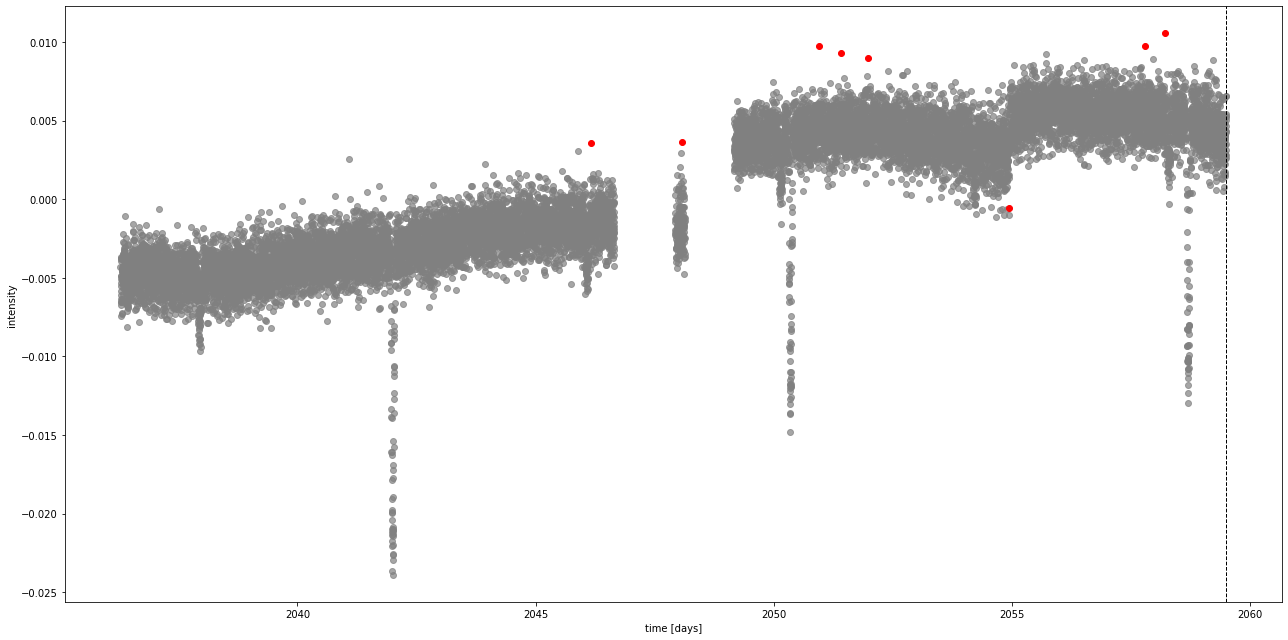

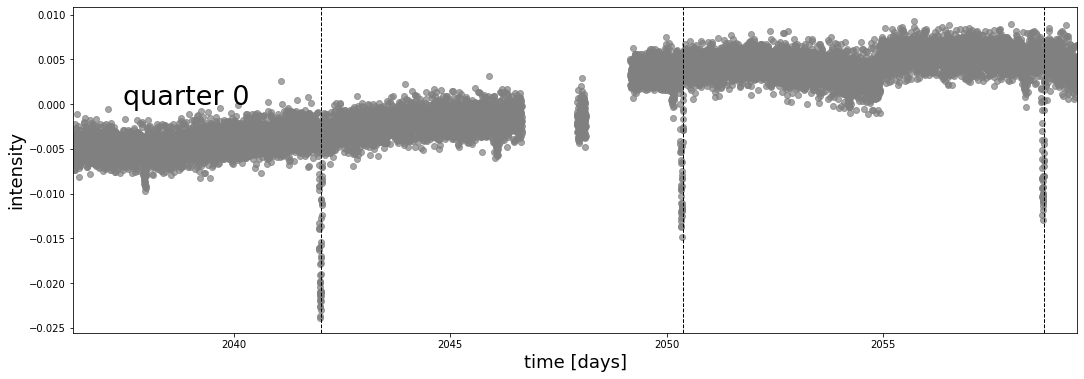

In [91]:
#kepler 1513 = koi-3678
#kepler 1519 = koi-3762
#from Holczer data on koi-4307 
#https://exoplanetarchive.ipac.caltech.edu/overview/TIC%20138888805
#    period = 160.85
#    t0 = 2454977.52
#    duration = 10.18


#toi-1796 = TIC 138819293
#t0 = 2458899.671523 #from exofop-tess

#pulls in light curve
sap_time, sap_lc, sap_lc_err, sap_mask, sap_mask_fitted_planet, \
t0s, period, duration, quarters, crowding, flux_fraction  = \
get_light_curve_multi('toi-1130', 'sap_flux', TESS=True, planet_number = 2, mask_width = 1.3)
                #user_periods = np.array([period]),
                #user_t0s = np.array([t0]),
                #user_durations = np.array([duration]))






#determine cadence of observation
cadence = deteremine_cadence(sap_time)

#find end time of kepler quarters
quarters_end = [el[1] for el in quarters]


#time between data points = 0.02 days
#time window = 0.02*30= 0.6 days
%matplotlib inline
%matplotlib inline

sap_time_out, sap_flux_out, sap_flux_err_out, sap_mask_out, sap_mask_fitted_planet_out, sap_moving_median = \
reject_outliers_out_of_transit(sap_time, sap_lc, sap_lc_err, sap_mask, sap_mask_fitted_planet, 30*cadence, 4)

plot_outliers(sap_time, sap_lc, sap_time_out, sap_flux_out, 
              sap_moving_median, quarters_end)


x_quarters, y_quarters, yerr_quarters, mask_quarters, mask_fitted_planet_quarters = \
split_around_problems(sap_time_out, sap_flux_out, sap_flux_err_out, 
                      sap_mask_out, sap_mask_fitted_planet_out, quarters_end)

plot_split_data(x_quarters, y_quarters, t0s)


x_quarters_w_transits, y_quarters_w_transits, yerr_quarters_w_transits, \
mask_quarters_w_transits, mask_fitted_planet_quarters_w_transits = \
find_quarters_with_transits(x_quarters, y_quarters, yerr_quarters, 
                            mask_quarters, mask_fitted_planet_quarters, t0s)



x_quarters_w_transits = np.concatenate(x_quarters_w_transits, axis=0, dtype='float64')
y_quarters_w_transits = np.concatenate(y_quarters_w_transits, axis=0, dtype='float64')
yerr_quarters_w_transits = np.concatenate(yerr_quarters_w_transits, axis=0, dtype='float64')
mask_quarters_w_transits = np.concatenate(mask_quarters_w_transits, axis=0, dtype=bool)
mask_fitted_planet_quarters_w_transits = np.concatenate(mask_fitted_planet_quarters_w_transits, axis=0, dtype=bool)


x_transits, y_transits, yerr_transits, mask_transits, mask_fitted_planet_transits = split_around_transits(x_quarters_w_transits, 
                                                                                                          y_quarters_w_transits, 
                                                                                                          yerr_quarters_w_transits, 
                                                                                                          mask_quarters_w_transits, 
                                                                                                          mask_fitted_planet_quarters_w_transits, 
                                                                                                          t0s, 1./2., period)

x_epochs = np.concatenate(x_transits, axis=0, dtype='float64')
y_epochs = np.concatenate(y_transits, axis=0, dtype='float64')
yerr_epochs = np.concatenate(yerr_transits, axis=0, dtype='float64')
mask_epochs = np.concatenate(mask_transits, axis=0, dtype=bool)
mask_fitted_planet_epochs = np.concatenate(mask_fitted_planet_transits, axis=0, dtype=bool)



<IPython.core.display.Javascript object>


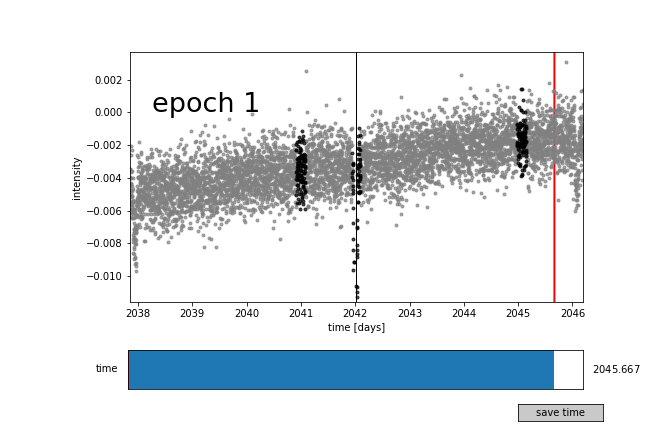

<IPython.core.display.Javascript object>


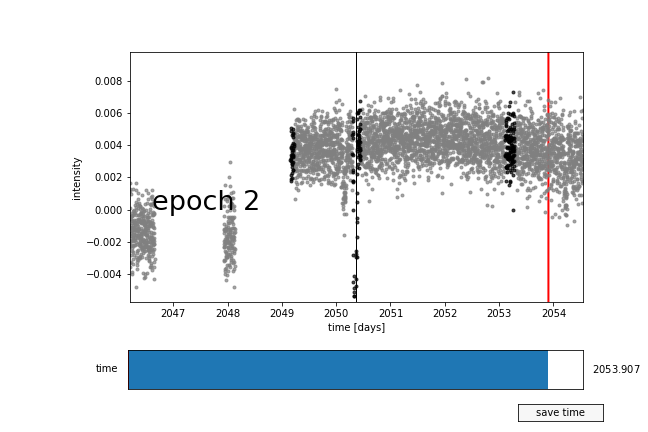

<IPython.core.display.Javascript object>


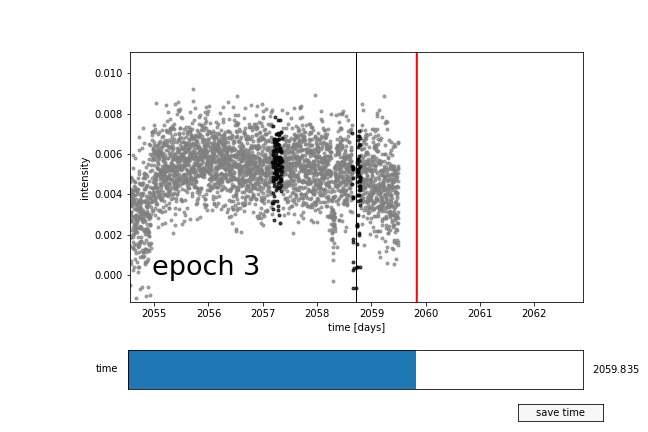

([<matplotlib.widgets.Slider at 0x167a12220>,
  <matplotlib.widgets.Button at 0x167bb7460>])

In [57]:

%matplotlib notebook
%matplotlib notebook


plot_transits(x_transits, y_transits, mask_transits, t0s, period)


In [419]:
#koi4307_sap_problem_times = problem_times
#sap_problem_times_koi3762 = problem_times
#koi3678_sap_problem_times = problem_times
print(koi3678_sap_problem_times)

[267.6252331775634, 285.308907123916, 399.1549852966182, 445.83988451498897, 598.9437188485937, 631.8353523888095, 734.0102057569189, 762.65775755001, 904.7977140368764, 937.3356740981652, 1072.0484875275633, 1094.6835901788945, 1186.60191265812, 1245.3117101600105, 1372.9510540108677, 1404.7816671143023, 1556.4708075321992, 1584.057338888509]


In [58]:
toi1130_sap_problem_times = problem_times
print(toi1130_sap_problem_times)

[2038.3612239951647, 2045.667183242993, 2050.2360878483883, 2053.9074241538297, 2058.4763287592255, 2059.834723192239]


In [107]:
import warnings
warnings.simplefilter('ignore', np.RankWarning)

%matplotlib inline
%matplotlib inline

x_trimmed, y_trimmed, yerr_trimmed, mask_trimmed, mask_fitted_planet_trimmed = \
trim_jump_times(x_epochs, y_epochs, yerr_epochs, 
                mask_epochs, mask_fitted_planet_epochs,
                t0s, period, toi1130_sap_problem_times)


# determine local window values for later use
# zoom in around local window
sap_local_x_epochs, sap_local_y_epochs, sap_local_yerr_epochs, \
sap_local_mask_epochs, sap_local_mask_fitted_planet_epochs = \
split_around_transits(np.concatenate(x_trimmed, axis=0, dtype='float64'), 
                      np.concatenate(y_trimmed, axis=0, dtype='float64'),
                      np.concatenate(yerr_trimmed, axis=0, dtype='float64'),
                      np.concatenate(mask_trimmed, axis=0, dtype=bool),
                      np.concatenate(mask_fitted_planet_trimmed, axis=0, dtype=bool),
                      t0s, float(6*duration/(24.))/period, period)
 

sap_local_x = np.concatenate(sap_local_x_epochs, axis=0, dtype='float64')
sap_local_y = np.concatenate(sap_local_y_epochs, axis=0, dtype='float64')
sap_local_yerr = np.concatenate(sap_local_yerr_epochs, axis=0, dtype='float64')
sap_local_mask = np.concatenate(sap_local_mask_epochs, axis=0, dtype=bool)
sap_local_mask_fitted_planet = np.concatenate(sap_local_mask_fitted_planet_epochs, axis=0, dtype=bool)

    

####################
####################
####################
# local detrending
print('local detrending')
sap_local_detrended = \
local_method(x_trimmed, y_trimmed, yerr_trimmed, 
             mask_trimmed, mask_fitted_planet_trimmed,
             t0s, duration, period)


# remove outliers in unmasked local detrended lc
sap_local_x_no_outliers, sap_local_detrended_no_outliers = \
reject_outliers_everywhere(sap_local_x, sap_local_detrended, sap_local_yerr, 5*cadence, 5, 10)

plot_individual_outliers(sap_local_x, sap_local_detrended, sap_local_x_no_outliers, sap_local_detrended_no_outliers,
                         t0s, period, float(6*duration/(24.))/period, 0.009)



####################
####################
####################
# polyAM detrending
print('polyAM detrending')
sap_poly_detrended, sap_poly_DWs = \
polynomial_method(x_trimmed, y_trimmed, yerr_trimmed, 
                  mask_trimmed, mask_fitted_planet_trimmed,
                  t0s, duration, period, sap_local_x_epochs)


# remove outliers in unmasked poly detrended lc
sap_poly_x_no_outliers, sap_poly_detrended_no_outliers = \
reject_outliers_everywhere(sap_local_x, sap_poly_detrended, sap_local_yerr, 5*cadence, 5, 10)

plot_individual_outliers(sap_local_x, sap_poly_detrended, sap_poly_x_no_outliers, sap_poly_detrended_no_outliers,
                         t0s, period, float(6*duration/(24.))/period, 0.009)




####################
####################
####################
# gp detrending
print('gp detrending')
sap_gp_detrended = \
gp_method(x_trimmed, y_trimmed, yerr_trimmed, 
          mask_trimmed, mask_fitted_planet_trimmed,
          t0s, duration, period)


# remove outliers in unmasked gp detrended lc
sap_gp_x_no_outliers, sap_gp_detrended_no_outliers = \
reject_outliers_everywhere(sap_local_x, sap_gp_detrended, sap_local_yerr, 5*cadence, 5, 10)

plot_individual_outliers(sap_local_x, sap_gp_detrended, sap_gp_x_no_outliers, sap_gp_detrended_no_outliers,
                         t0s, period, float(6*duration/(24.))/period, 0.009)





####################
####################
####################
# CoFiAM detrending
print('CoFiAM detrending')
sap_cofiam_detrended, sap_cofiam_DWs = \
cofiam_method(x_trimmed, y_trimmed, yerr_trimmed, 
              mask_trimmed, mask_fitted_planet_trimmed,
              t0s, duration, period, sap_local_x_epochs)

# remove outliers in unmasked CoFiAM detrended lc
sap_cofiam_x_no_outliers, sap_cofiam_detrended_no_outliers = \
reject_outliers_everywhere(sap_local_x, sap_cofiam_detrended, sap_local_yerr, 5*cadence, 5, 10)

plot_individual_outliers(sap_local_x, sap_cofiam_detrended, sap_cofiam_x_no_outliers, sap_cofiam_detrended_no_outliers,
                         t0s, period, float(6*duration/(24.))/period, 0.009)




2042.0221360000837
[8.350381]
[0.06047628]
2050.372517000084
[8.350381]
[0.06047628]
2058.722898000084
[8.350381]
[0.06047628]
local detrending
2042.0221360000837
[8.350381]
[0.06047628]
2050.372517000084
[8.350381]
[0.06047628]
2058.722898000084
[8.350381]
[0.06047628]
0 outliers
outlier times: []
polyAM detrending
2042.0221360000837
[8.350381]
[0.06047628]
2050.372517000084
[8.350381]
[0.06047628]
2058.722898000084
[8.350381]
[0.06047628]
[0.3331159950055147, 1.0157230550514436, 0.7092373786563966]
0 outliers
outlier times: []
gp detrending


optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 26561.179962418035 -> 26630.174449317787
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 12557.197958155748 -> 13158.504193776776
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 3175.3269927693786 -> 3380.4817065824504


2042.0221360000837
[8.350381]
[0.06047628]
2050.372517000084
[8.350381]
[0.06047628]
2058.722898000084
[8.350381]
[0.06047628]
0 outliers
outlier times: []
CoFiAM detrending
2042.0221360000837
[8.350381]
[0.06047628]
2050.372517000084
[8.350381]
[0.06047628]
2058.722898000084
[8.350381]
[0.06047628]
[0.2926134331439669, 0.772718610573217, 0.03945390360596595]
0 outliers
outlier times: []


             tic_id      t0 [BJD]  period [days]  duration [hours]
361   TIC 254113311  2.458659e+06       4.066499              2.30
3218  TIC 254113311  2.458658e+06       8.350381              2.02
Exoplanet Archive: Planet Comparison Table
------------------------------------------

             tic_id      t0 [BJD]  period [days]  duration [hours]
361   TIC 254113311  2.458659e+06       4.066499              2.30
3218  TIC 254113311  2.458658e+06       8.350381              2.02
here
LightCurveCollection of 1 objects:
    0: <TessLightCurve LABEL="TIC 254113311" SECTOR=27 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
good


/Users/Danielyahalomi/anaconda3/envs/py39/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
/Users/Danielyahalomi/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/Danielyahalomi/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


3 outliers
2042.0221360000837
[8.350381]
0.5
2050.372517000084
[8.350381]
0.5


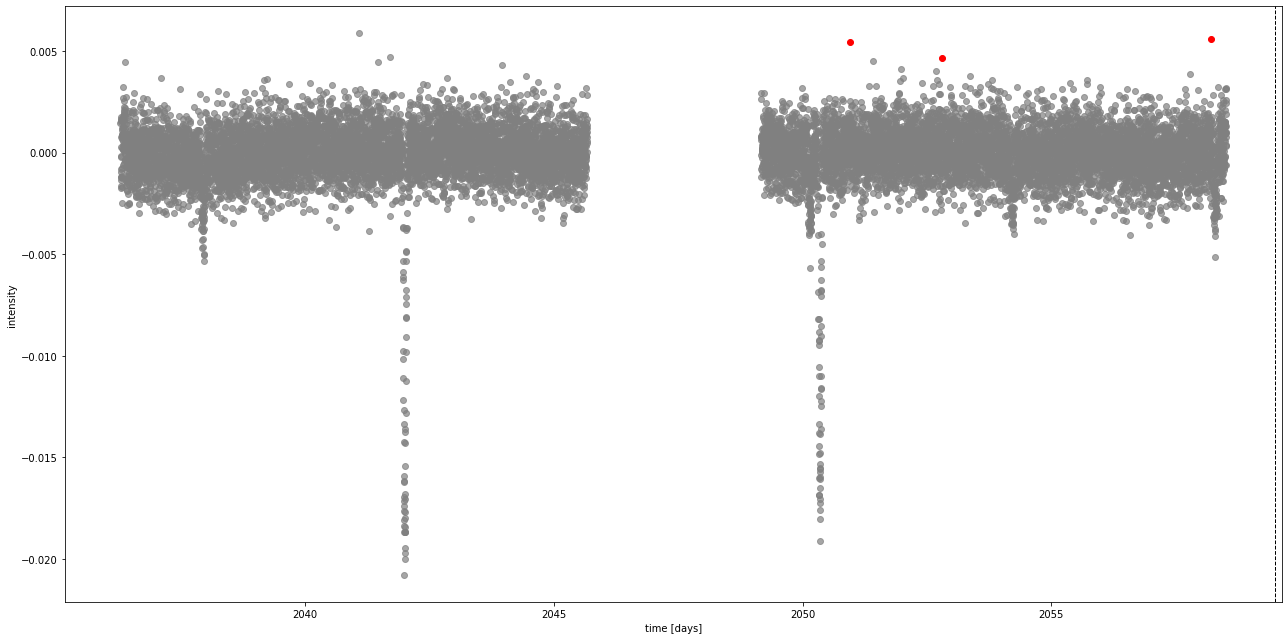

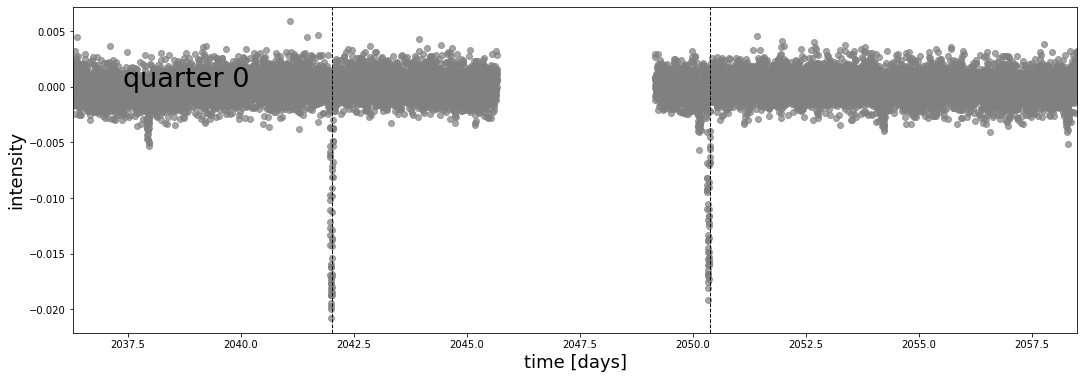

In [108]:
#kepler 1513 = koi-3678
#kepler 1519 = koi-3762
#from Holczer data on koi-4307 
#https://exoplanetarchive.ipac.caltech.edu/overview/TIC%20138888805
#    period = 160.85
#    t0 = 2454977.52
#    duration = 10.18


#toi-1796 = TIC 138819293
#t0 = 2458899.671523 #from exofop-tess

#pulls in light curve
pdc_time, pdc_lc, pdc_lc_err, pdc_mask, pdc_mask_fitted_planet, \
t0s, period, duration, quarters, crowding, flux_fraction  = \
get_light_curve_multi('toi-1130', 'pdcsap_flux', TESS=True, planet_number = 2, mask_width = 1.3)
                #user_periods = np.array([period]),
                #user_t0s = np.array([t0]),
                #user_durations = np.array([duration]))






#determine cadence of observation
cadence = deteremine_cadence(sap_time)

#find end time of kepler quarters
quarters_end = [el[1] for el in quarters]


#time between data points = 0.02 days
#time window = 0.02*30= 0.6 days
%matplotlib inline
%matplotlib inline

pdc_time_out, pdc_flux_out, pdc_flux_err_out, pdc_mask_out, pdc_mask_fitted_planet_out, pdc_moving_median = \
reject_outliers_out_of_transit(pdc_time, pdc_lc, pdc_lc_err, pdc_mask, pdc_mask_fitted_planet, 30*cadence, 4)

plot_outliers(pdc_time, pdc_lc, pdc_time_out, pdc_flux_out, 
              pdc_moving_median, quarters_end)


x_quarters, y_quarters, yerr_quarters, mask_quarters, mask_fitted_planet_quarters = \
split_around_problems(pdc_time_out, pdc_flux_out, pdc_flux_err_out, 
                      pdc_mask_out, pdc_mask_fitted_planet_out, quarters_end)

plot_split_data(x_quarters, y_quarters, t0s)


x_quarters_w_transits, y_quarters_w_transits, yerr_quarters_w_transits, \
mask_quarters_w_transits, mask_fitted_planet_quarters_w_transits = \
find_quarters_with_transits(x_quarters, y_quarters, yerr_quarters, 
                            mask_quarters, mask_fitted_planet_quarters, t0s)



x_quarters_w_transits = np.concatenate(x_quarters_w_transits, axis=0, dtype='float64')
y_quarters_w_transits = np.concatenate(y_quarters_w_transits, axis=0, dtype='float64')
yerr_quarters_w_transits = np.concatenate(yerr_quarters_w_transits, axis=0, dtype='float64')
mask_quarters_w_transits = np.concatenate(mask_quarters_w_transits, axis=0, dtype=bool)
mask_fitted_planet_quarters_w_transits = np.concatenate(mask_fitted_planet_quarters_w_transits, axis=0, dtype=bool)


x_transits, y_transits, yerr_transits, mask_transits, mask_fitted_planet_transits = split_around_transits(x_quarters_w_transits, 
                                                                                                          y_quarters_w_transits, 
                                                                                                          yerr_quarters_w_transits, 
                                                                                                          mask_quarters_w_transits, 
                                                                                                          mask_fitted_planet_quarters_w_transits, 
                                                                                                          t0s, 1./2., period)

x_epochs = np.concatenate(x_transits, axis=0, dtype='float64')
y_epochs = np.concatenate(y_transits, axis=0, dtype='float64')
yerr_epochs = np.concatenate(yerr_transits, axis=0, dtype='float64')
mask_epochs = np.concatenate(mask_transits, axis=0, dtype=bool)
mask_fitted_planet_epochs = np.concatenate(mask_fitted_planet_transits, axis=0, dtype=bool)



In [109]:
'''
#kepler 1513 = koi-3678
#kepler 1519 = koi-3762

#from Holczer data on koi-4307 
#https://exoplanetarchive.ipac.caltech.edu/overview/TIC%20138888805
    #period = 160.85
    #t0 = 2454977.52
    #duration = 10.18
    
#toi-1796 = TIC 138819293
#t0 = 2458899.671523 #from exofop-tess

pdc_time, pdc_lc, pdc_lc_err, pdc_mask, \
t0s, period, duration, kepler_quarters, crowding, flux_fraction  = \
get_light_curve_multi('toi-1130', 'pdcsap_flux', TESS=True, planet_number = 2, mask_width = 1.3)
                #user_periods = np.array([period]),
                #user_t0s= np.array([t0]),
                #user_durations = np.array([duration]))

cadence = deteremine_cadence(pdc_time)


quarters_end = [el[1] for el in quarters]

#time between data points = 0.02 days
#time window = 0.02*30= 0.6 days
%matplotlib inline
%matplotlib inline

pdc_time_out, pdc_flux_out, pdc_flux_err_out, pdc_mask_out, pdc_moving_median = \
reject_outliers_out_of_transit(pdc_time, pdc_lc, pdc_lc_err, pdc_mask, 30*cadence, 4)

plot_outliers(pdc_time, pdc_lc, pdc_time_out, pdc_flux_out, 
              pdc_moving_median, quarters_end)



x_quarters, y_quarters, yerr_quarters, mask_quarters = \
split_around_problems(pdc_time_out, pdc_flux_out, pdc_flux_err_out, 
                      pdc_mask_out, quarters_end)

plot_split_data(x_quarters, y_quarters, t0s)



x_quarters_w_transits, y_quarters_w_transits, yerr_quarters_w_transits, mask_quarters_w_transits = \
find_quarters_with_transits(x_quarters, y_quarters, yerr_quarters, mask_quarters, t0s)



x_quarters_w_transits = np.concatenate(x_quarters_w_transits, axis=0, dtype='float64')
y_quarters_w_transits = np.concatenate(y_quarters_w_transits, axis=0, dtype='float64')
yerr_quarters_w_transits = np.concatenate(yerr_quarters_w_transits, axis=0, dtype='float64')
mask_quarters_w_transits = np.concatenate(mask_quarters_w_transits, axis=0, dtype=bool)


x_transits, y_transits, yerr_transits, mask_transits = split_around_transits(x_quarters_w_transits, 
                                                                             y_quarters_w_transits, 
                                                                             yerr_quarters_w_transits, 
                                                                             mask_quarters_w_transits, 
                                                                             t0s, 1./2., period)

x_epochs = np.concatenate(x_transits, axis=0, dtype='float64')
y_epochs = np.concatenate(y_transits, axis=0, dtype='float64')
yerr_epochs = np.concatenate(yerr_transits, axis=0, dtype='float64')
mask_epochs = np.concatenate(mask_transits, axis=0, dtype=bool)
'''

"\n#kepler 1513 = koi-3678\n#kepler 1519 = koi-3762\n\n#from Holczer data on koi-4307 \n#https://exoplanetarchive.ipac.caltech.edu/overview/TIC%20138888805\n    #period = 160.85\n    #t0 = 2454977.52\n    #duration = 10.18\n    \n#toi-1796 = TIC 138819293\n#t0 = 2458899.671523 #from exofop-tess\n\npdc_time, pdc_lc, pdc_lc_err, pdc_mask, t0s, period, duration, kepler_quarters, crowding, flux_fraction  = get_light_curve_multi('toi-1130', 'pdcsap_flux', TESS=True, planet_number = 2, mask_width = 1.3)\n                #user_periods = np.array([period]),\n                #user_t0s= np.array([t0]),\n                #user_durations = np.array([duration]))\n\ncadence = deteremine_cadence(pdc_time)\n\n\nquarters_end = [el[1] for el in quarters]\n\n#time between data points = 0.02 days\n#time window = 0.02*30= 0.6 days\n%matplotlib inline\n%matplotlib inline\n\npdc_time_out, pdc_flux_out, pdc_flux_err_out, pdc_mask_out, pdc_moving_median = reject_outliers_out_of_transit(pdc_time, pdc_lc, pdc_lc_

<IPython.core.display.Javascript object>


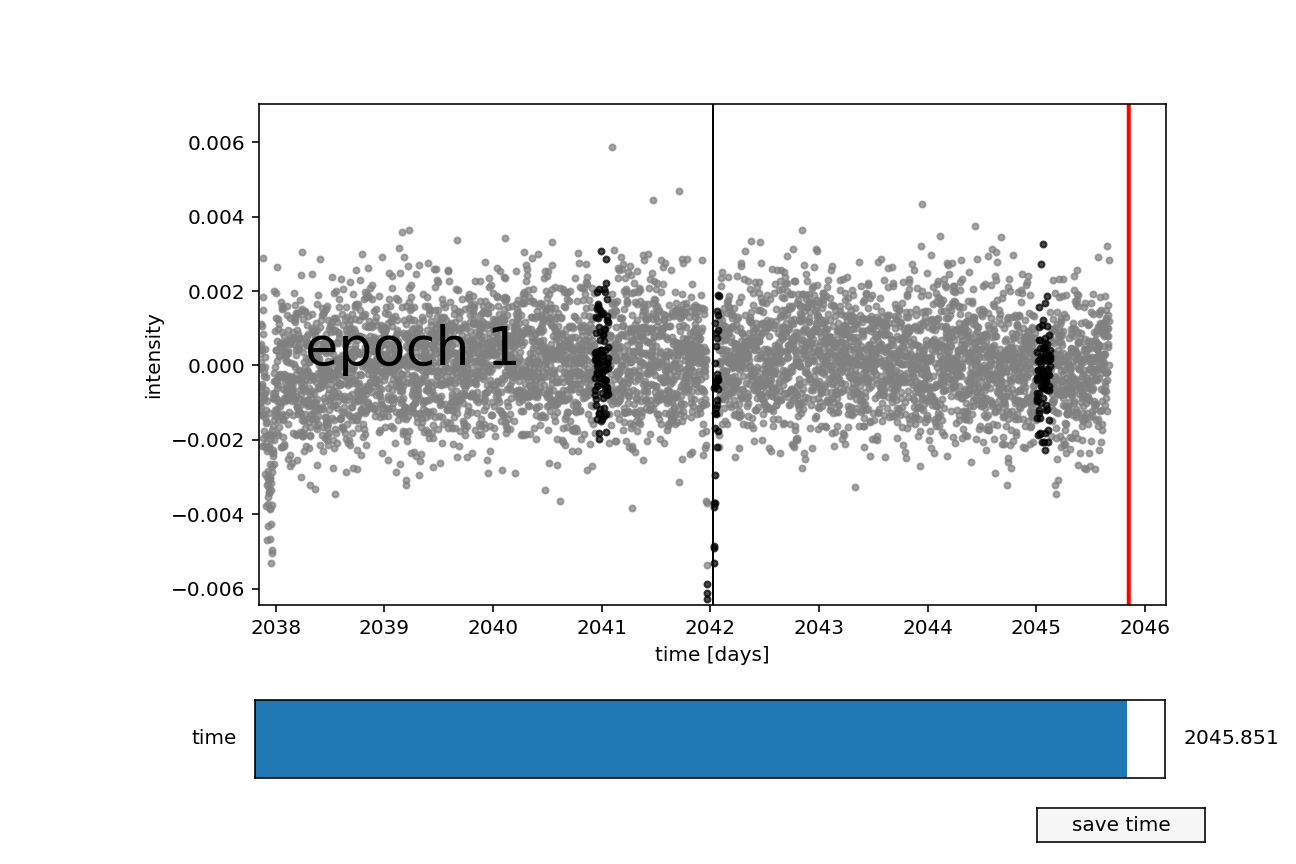

<IPython.core.display.Javascript object>


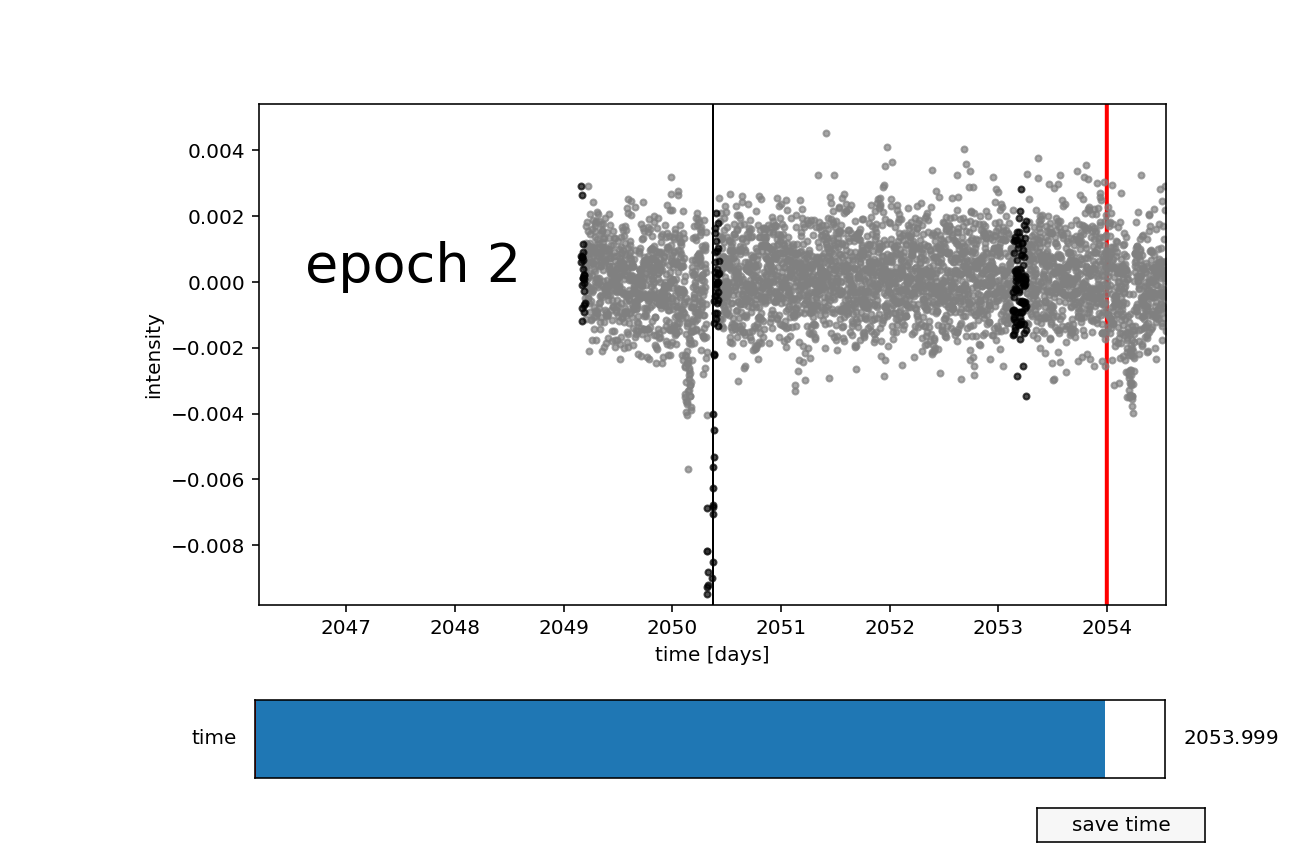

([<matplotlib.widgets.Slider at 0x16eb7e1c0>,
  <matplotlib.widgets.Button at 0x16d02fa30>])

In [110]:

%matplotlib notebook
%matplotlib notebook


plot_transits(x_transits, y_transits, mask_transits, t0s, period)




In [113]:
#koi3678_pdc_problem_times = [258.78339620438715, 357.1046233461075, 358.8362086989343, 450.08396626211356, 598.9437188485937, 630.7743319520283, 732.5955118412107, 805.0985750212564, 905.5050609947306, 936.9820006192382, 1072.0484875275633, 1095.3909371367486, 1187.309259615974, 1277.495996742372, 1371.1826866162323, 1414.6845245242598, 1557.5318279689802, 1583.703665409582]


In [114]:
toi1130_pdc_problem_times = problem_times
print(toi1130_pdc_problem_times)

[2038.1960138614197, 2045.8507500582648, 2050.272801211443, 2053.999207561466]


In [140]:
problem_times_toi1796 = [1899.3842204938856,
 1900.9883492202757,
 1900.999368887179,
 1903.6322323402758,
 1903.6432520071787,
 1905.9797003695296,
 1906.2987592483846,
 1908.9199985802757,
 1908.9426423683847,
 1911.5580696396728,
 1916.868479667782,
 1919.489718999673,
 1919.518174848385,
 1922.133602119673,
 1922.1620579683852,
 1924.7716731790704,
 1924.8001290277823,
 1926.5553713298468]

In [119]:
import warnings
warnings.simplefilter('ignore', np.RankWarning)

%matplotlib inline
%matplotlib inline

x_trimmed, y_trimmed, yerr_trimmed, mask_trimmed, mask_fitted_planet_trimmed = \
trim_jump_times(x_epochs, y_epochs, yerr_epochs, 
                mask_epochs, mask_fitted_planet_epochs,
                t0s, period, [])


# determine local window values for later use
# zoom in around local window
pdc_local_x_epochs, pdc_local_y_epochs, pdc_local_yerr_epochs, \
pdc_local_mask_epochs, pdc_local_mask_fitted_planet_epochs = \
split_around_transits(np.concatenate(x_trimmed, axis=0, dtype='float64'), 
                      np.concatenate(y_trimmed, axis=0, dtype='float64'),
                      np.concatenate(yerr_trimmed, axis=0, dtype='float64'),
                      np.concatenate(mask_trimmed, axis=0, dtype=bool),
                      np.concatenate(mask_fitted_planet_trimmed, axis=0, dtype=bool),
                      t0s, float(6*duration/(24.))/period, period)
 

pdc_local_x = np.concatenate(pdc_local_x_epochs, axis=0, dtype='float64')
pdc_local_y = np.concatenate(pdc_local_y_epochs, axis=0, dtype='float64')
pdc_local_yerr = np.concatenate(pdc_local_yerr_epochs, axis=0, dtype='float64')
pdc_local_mask = np.concatenate(pdc_local_mask_epochs, axis=0, dtype=bool)
pdc_local_mask_fitted_planet = np.concatenate(pdc_local_mask_fitted_planet_epochs, axis=0, dtype=bool)

    

####################
####################
####################
# local detrending
print('local detrending')
pdc_local_detrended = \
local_method(x_trimmed, y_trimmed, yerr_trimmed, 
             mask_trimmed, mask_fitted_planet_trimmed,
             t0s, duration, period)


# remove outliers in unmasked local detrended lc
pdc_local_x_no_outliers, pdc_local_detrended_no_outliers = \
reject_outliers_everywhere(pdc_local_x, pdc_local_detrended, pdc_local_yerr, 5*cadence, 5, 10)

plot_individual_outliers(pdc_local_x, pdc_local_detrended, pdc_local_x_no_outliers, pdc_local_detrended_no_outliers,
                         t0s, period, float(6*duration/(24.))/period, 0.009)



####################
####################
####################
# polyAM detrending
print('polyAM detrending')
pdc_poly_detrended, pdc_poly_DWs = \
polynomial_method(x_trimmed, y_trimmed, yerr_trimmed, 
                  mask_trimmed, mask_fitted_planet_trimmed,
                  t0s, duration, period, pdc_local_x_epochs)


# remove outliers in unmasked poly detrended lc
pdc_poly_x_no_outliers, pdc_poly_detrended_no_outliers = \
reject_outliers_everywhere(pdc_local_x, pdc_poly_detrended, pdc_local_yerr, 5*cadence, 5, 10)

plot_individual_outliers(pdc_local_x, pdc_poly_detrended, pdc_poly_x_no_outliers, pdc_poly_detrended_no_outliers,
                         t0s, period, float(6*duration/(24.))/period, 0.009)




####################
####################
####################
# gp detrending
print('gp detrending')
pdc_gp_detrended = \
gp_method(x_trimmed, y_trimmed, yerr_trimmed, 
          mask_trimmed, mask_fitted_planet_trimmed,
          t0s, duration, period)


# remove outliers in unmasked gp detrended lc
pdc_gp_x_no_outliers, pdc_gp_detrended_no_outliers = \
reject_outliers_everywhere(pdc_local_x, pdc_gp_detrended, pdc_local_yerr, 5*cadence, 5, 10)

plot_individual_outliers(pdc_local_x, pdc_gp_detrended, pdc_gp_x_no_outliers, pdc_gp_detrended_no_outliers,
                         t0s, period, float(6*duration/(24.))/period, 0.009)





####################
####################
####################
# CoFiAM detrending
print('CoFiAM detrending')
pdc_cofiam_detrended, pdc_cofiam_DWs = \
cofiam_method(x_trimmed, y_trimmed, yerr_trimmed, 
              mask_trimmed, mask_fitted_planet_trimmed,
              t0s, duration, period, pdc_local_x_epochs)

# remove outliers in unmasked CoFiAM detrended lc
pdc_cofiam_x_no_outliers, pdc_cofiam_detrended_no_outliers = \
reject_outliers_everywhere(pdc_local_x, pdc_cofiam_detrended, pdc_local_yerr, 5*cadence, 5, 10)

plot_individual_outliers(pdc_local_x, pdc_cofiam_detrended, pdc_cofiam_x_no_outliers, pdc_cofiam_detrended_no_outliers,
                         t0s, period, float(6*duration/(24.))/period, 0.009)



2042.0221360000837
[8.350381]
0.5
2050.372517000084
[8.350381]
0.5
2042.0221360000837
[8.350381]
[0.06047628]
2050.372517000084
[8.350381]
[0.06047628]
local detrending
2042.0221360000837
[8.350381]
[0.06047628]
2050.372517000084
[8.350381]
[0.06047628]
0 outliers
outlier times: []
polyAM detrending
2042.0221360000837
[8.350381]
[0.06047628]
2050.372517000084
[8.350381]
[0.06047628]
[0.3395415148854326, 0.8964900261416171]
0 outliers
outlier times: []
gp detrending


optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 26328.034077101882 -> 28713.70155947106
optimizing logp for variables: [sigma_gp, mean, rho_gp]


message: Desired error not necessarily achieved due to precision loss.
logp: 18463.919516494887 -> 19716.594896610022


2042.0221360000837
[8.350381]
[0.06047628]
2050.372517000084
[8.350381]
[0.06047628]
0 outliers
outlier times: []
CoFiAM detrending
2042.0221360000837
[8.350381]
[0.06047628]
2050.372517000084
[8.350381]
[0.06047628]
[0.33158025551687786, 0.741657492971615]
0 outliers
outlier times: []


In [115]:
'''
import warnings
warnings.simplefilter('ignore', np.RankWarning)


x_trimmed, y_trimmed, yerr_trimmed, mask_trimmed = \
trim_jump_times(x_epochs, y_epochs, yerr_epochs, mask_epochs, 
                t0s, period, toi1130_pdc_problem_times)


# determine local window values for later use
# zoom in around local window
pdc_local_x_epochs, pdc_local_y_epochs, pdc_local_yerr_epochs, pdc_local_mask_epochs = \
split_around_transits(np.concatenate(x_trimmed, axis=0, dtype='float64'), 
                      np.concatenate(y_trimmed, axis=0, dtype='float64'),
                      np.concatenate(yerr_trimmed, axis=0, dtype='float64'),
                      np.concatenate(mask_trimmed, axis=0, dtype=bool),
                      t0s, float(6*duration/(24.))/period, period)


pdc_local_x = np.concatenate(pdc_local_x_epochs, axis=0, dtype='float64')
pdc_local_y = np.concatenate(pdc_local_y_epochs, axis=0, dtype='float64')
pdc_local_yerr = np.concatenate(pdc_local_yerr_epochs, axis=0, dtype='float64')
pdc_local_mask = np.concatenate(pdc_local_mask_epochs, axis=0, dtype=bool)


###################
###################
###################
# local detrending
print('local detrending')
pdc_local_detrended = \
local_method(x_trimmed, y_trimmed, yerr_trimmed, mask_trimmed, 
             t0s, duration, period)

# remove outliers in unmasked local detrended lc
pdc_local_x_no_outliers, pdc_local_detrended_no_outliers = \
reject_outliers_everywhere(pdc_local_x, pdc_local_detrended, pdc_local_yerr, 5*cadence, 5, 10)

plot_individual_outliers(pdc_local_x, pdc_local_detrended, pdc_local_x_no_outliers, pdc_local_detrended_no_outliers,
                         t0s, period, float(6*duration/(24.))/period, 0.009)




###################
###################
###################
# polyAM detrending
print('polyAM detrending')
pdc_poly_detrended, pdc_poly_DWs = \
polynomial_method(x_trimmed, y_trimmed, yerr_trimmed, mask_trimmed, 
                  t0s, duration, period, pdc_local_x_epochs)

# remove outliers in unmasked poly detrended lc
pdc_poly_x_no_outliers, pdc_poly_detrended_no_outliers = \
reject_outliers_everywhere(pdc_local_x, pdc_poly_detrended, pdc_local_yerr, 5*cadence, 5, 10)

plot_individual_outliers(pdc_local_x, pdc_poly_detrended, pdc_poly_x_no_outliers, pdc_poly_detrended_no_outliers,
                         t0s, period, float(6*duration/(24.))/period, 0.009)





###################
###################
###################
# gp detrending
print('gp detrending')
pdc_gp_detrended = \
gp_method(x_trimmed, y_trimmed, yerr_trimmed, mask_trimmed,
          t0s, duration, period)

# remove outliers in unmasked gp detrended lc
pdc_gp_x_no_outliers, pdc_gp_detrended_no_outliers = \
reject_outliers_everywhere(pdc_local_x, pdc_gp_detrended, pdc_local_yerr, 5*cadence, 5, 10)

plot_individual_outliers(pdc_local_x, pdc_gp_detrended, pdc_gp_x_no_outliers, pdc_gp_detrended_no_outliers,
                         t0s, period, float(6*duration/(24.))/period, 0.009)



###################
###################
###################
# CoFiAM detrending
print('CoFiAM detrending')
pdc_cofiam_detrended, pdc_cofiam_DWs = \
cofiam_method(x_trimmed, y_trimmed, yerr_trimmed, mask_trimmed,
              t0s, duration, period, pdc_local_x_epochs)

# remove outliers in unmasked cofiam detrended lc
pdc_cofiam_x_no_outliers, pdc_cofiam_detrended_no_outliers = \
reject_outliers_everywhere(pdc_local_x, pdc_cofiam_detrended, pdc_local_yerr, 5*cadence, 5, 10)

plot_individual_outliers(pdc_local_x, pdc_cofiam_detrended, pdc_cofiam_x_no_outliers, pdc_cofiam_detrended_no_outliers,
                         t0s, period, float(6*duration/(24.))/period, 0.009)


'''

TypeError: trim_jump_times() missing 1 required positional argument: 'jump_times'

In [190]:
x_detrended,\
[sap_local_detrended2, sap_poly_detrended2, sap_cofiam_detrended2, sap_gp_detrended2],\
[pdc_local_detrended2, pdc_poly_detrended2, pdc_cofiam_detrended2, pdc_gp_detrended2],\
yerr_detrended, mask_detrended, mask_fitted_planet_detrended = \
add_nans_for_missing_data(sap_local_x, [sap_local_detrended, sap_poly_detrended, sap_cofiam_detrended, sap_gp_detrended], sap_local_yerr, sap_local_mask, sap_local_mask_fitted_planet,
                          pdc_local_x, [pdc_local_detrended, pdc_poly_detrended, pdc_cofiam_detrended, pdc_gp_detrended], pdc_local_yerr, pdc_local_mask, pdc_local_mask_fitted_planet)


pdc length in:  1446
sap length in:  1722
---
pdc length out:  1986
sap length out:  1986





In [147]:
for ii in range(0, 10):
    if 1<10:
        print('hi')
        break

hi


In [158]:
green2, green1 = '#355E3B', '#18A558'
blue2, blue1 = '#000080', '#4682B4'
purple2, purple1 = '#2E0854','#9370DB'
red2, red1 = '#770737', '#EC8B80'


colors = [red1, red2,
          blue1, blue2,
          green1, green2,
          purple1, purple2]

In [160]:
print(t0s)

[2042.022136 2050.372517]


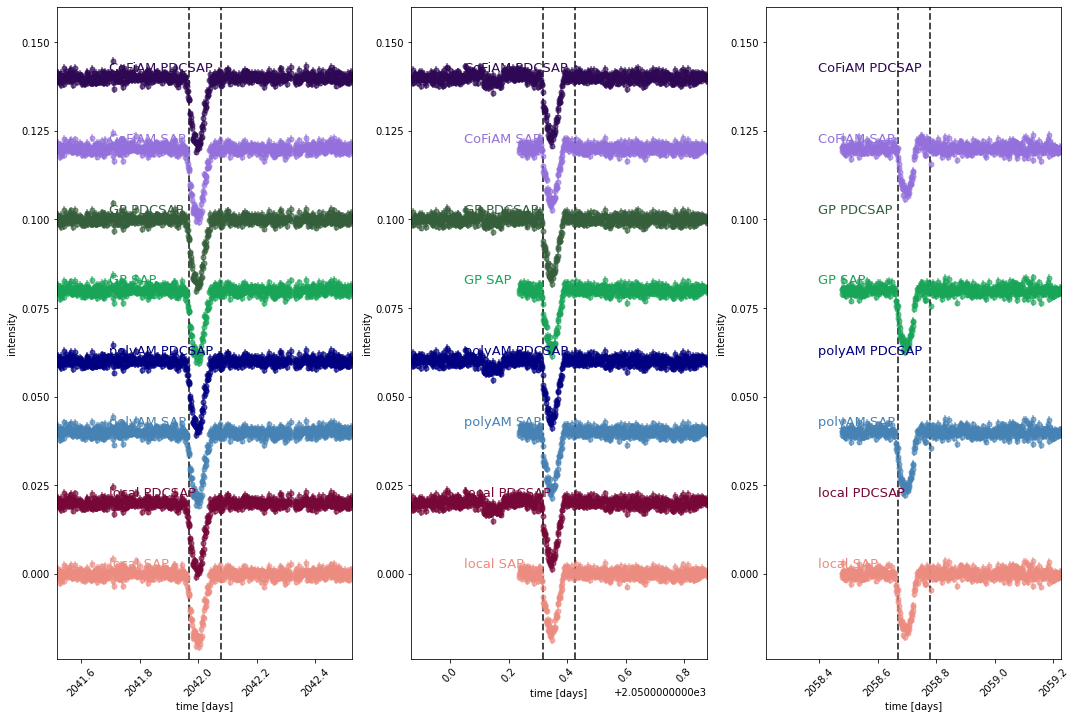

In [193]:

%matplotlib inline



y_detrended = [sap_local_detrended2, pdc_local_detrended2,
               sap_poly_detrended2, pdc_poly_detrended2,
               sap_gp_detrended2, pdc_gp_detrended2,
               sap_cofiam_detrended2, pdc_cofiam_detrended2]




detrend_label = ['local SAP', 'local PDCSAP',
                 'polyAM SAP', 'polyAM PDCSAP',
                 'GP SAP', 'GP PDCSAP', 
                 'CoFiAM SAP', 'CoFiAM PDCSAP']

plot_detrended_lc(x_detrended, y_detrended, yerr_detrended, detrend_label,
                  t0s_sap, float(6*duration/(24.))/period, period,
                  colors, duration, depth = 0.02,
                  figname = './figures/toi1130_April14.pdf'
)



In [194]:
print('sap local')
sap_sigmas_local = test_DW_per_epoch(x_detrended, sap_local_detrended2, yerr_detrended, 
                                     mask_detrended, mask_fitted_planet_detrended,
                                     period, t0s, duration)

print('sap poly')
sap_sigmas_poly = test_DW_per_epoch(x_detrended, sap_poly_detrended2, yerr_detrended, 
                                    mask_detrended, mask_fitted_planet_detrended,
                                    period, t0s, duration)

print('sap cofiam')
sap_sigmas_cofiam = test_DW_per_epoch(x_detrended, sap_cofiam_detrended2, yerr_detrended, 
                                      mask_detrended, mask_fitted_planet_detrended,
                                      period, t0s, duration)

print('sap gp')
sap_sigmas_gp = test_DW_per_epoch(x_detrended, sap_gp_detrended2, yerr_detrended, 
                                  mask_detrended, mask_fitted_planet_detrended,
                                  period, t0s, duration)




print('pdc local')
pdc_sigmas_local = test_DW_per_epoch(x_detrended, pdc_local_detrended2, yerr_detrended, 
                                     mask_detrended, mask_fitted_planet_detrended,
                                     period, t0s, duration)

print('pdc poly')
pdc_sigmas_poly = test_DW_per_epoch(x_detrended, pdc_poly_detrended2, yerr_detrended, 
                                    mask_detrended, mask_fitted_planet_detrended,
                                    period, t0s, duration)

print('pdc cofiam')
pdc_sigmas_cofiam = test_DW_per_epoch(x_detrended, pdc_cofiam_detrended2, yerr_detrended, 
                                      mask_detrended, mask_fitted_planet_detrended,
                                      period, t0s, duration)

print('pdc gp')
pdc_sigmas_gp = test_DW_per_epoch(x_detrended, pdc_gp_detrended2, yerr_detrended, 
                                  mask_detrended, mask_fitted_planet_detrended,
                                  period, t0s, duration)




sap local
sap poly
sap cofiam
sap gp
pdc local
pdc poly
pdc cofiam
pdc gp


In [195]:
sap_local_detrended_postDW = reject_epochs_by_DW(x_detrended, sap_local_detrended2, yerr_detrended, mask_detrended, mask_fitted_planet_detrended, sap_sigmas_local)
sap_poly_detrended_postDW = reject_epochs_by_DW(x_detrended, sap_poly_detrended2, yerr_detrended, mask_detrended, mask_fitted_planet_detrended, sap_sigmas_poly)
sap_cofiam_detrended_postDW = reject_epochs_by_DW(x_detrended, sap_cofiam_detrended2, yerr_detrended, mask_detrended, mask_fitted_planet_detrended, sap_sigmas_cofiam)
sap_gp_detrended_postDW = reject_epochs_by_DW(x_detrended, sap_gp_detrended2, yerr_detrended, mask_detrended, mask_fitted_planet_detrended, sap_sigmas_gp)

pdc_local_detrended_postDW = reject_epochs_by_DW(x_detrended, pdc_local_detrended2, yerr_detrended, mask_detrended, mask_fitted_planet_detrended, pdc_sigmas_local)
pdc_poly_detrended_postDW = reject_epochs_by_DW(x_detrended, pdc_poly_detrended2, yerr_detrended, mask_detrended, mask_fitted_planet_detrended, pdc_sigmas_poly)
pdc_cofiam_detrended_postDW = reject_epochs_by_DW(x_detrended, pdc_cofiam_detrended2, yerr_detrended, mask_detrended, mask_fitted_planet_detrended, pdc_sigmas_cofiam)
pdc_gp_detrended_postDW = reject_epochs_by_DW(x_detrended, pdc_gp_detrended2, yerr_detrended, mask_detrended, mask_fitted_planet_detrended, pdc_sigmas_gp)




In [204]:
print(len(x_detrended))
print(len(mask_fitted_planet_detrended))
print(sap_sigmas_gp)

1986
1986
[1.7606361852915167, inf]


ValueError: 'x' and 'y' must have the same size

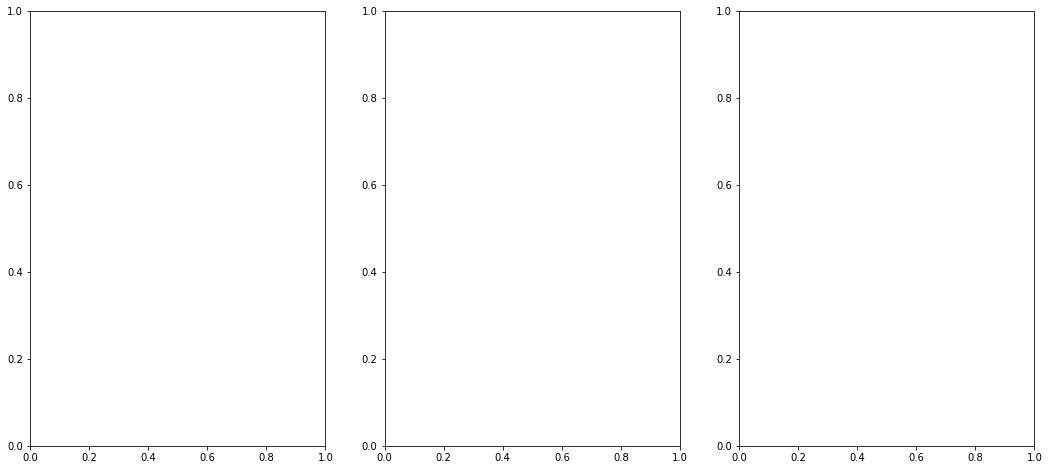

In [184]:
%matplotlib inline
%matplotlib inline

import matplotlib.pyplot as plt

y_detrended = [sap_local_detrended_postDW, pdc_local_detrended_postDW,
               sap_poly_detrended_postDW, pdc_poly_detrended_postDW,
               sap_gp_detrended_postDW, pdc_gp_detrended_postDW,
               sap_cofiam_detrended_postDW, pdc_cofiam_detrended_postDW]


detrend_label = ['local SAP', 'local PDC',
                 'polyAM SAP', 'polyAM PDC',
                 'GP SAP', 'GP PDC',
                 'CoFiAM SAP', 'CoFiAM PDC']

plot_detrended_lc(x_detrended, y_detrended, yerr_detrended, detrend_label,
                  t0s, float(6*duration/(24.))/period, period,
                  colors, duration, depth = 0.009,
                  figname = './figures/toi1130_April14_DWrejected.pdf')






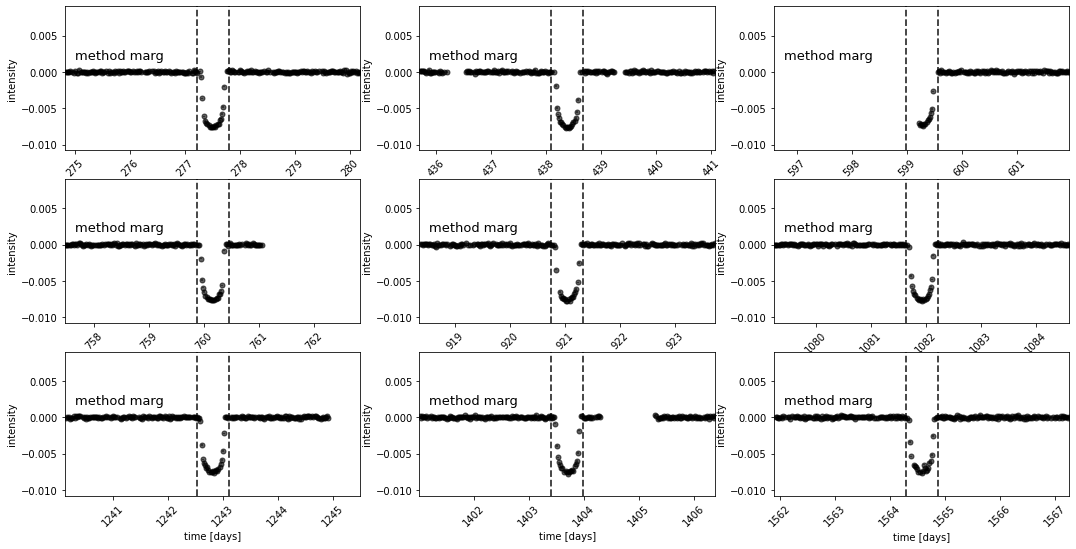

In [438]:
#y_detrended = [sap_local_detrended, pdcsap_local_detrended,
#               sap_gp_detrended, pdcsap_gp_detrended]
from scipy.stats import median_abs_deviation

y_detrended = np.array(y_detrended)
y_detrended_transpose = y_detrended.T

method_marg_detrended = np.nanmedian(y_detrended_transpose, axis=1)
MAD = median_abs_deviation(y_detrended_transpose, axis=1, scale=1/1.4826, nan_policy = 'omit')

yerr_detrended = np.sqrt(yerr_detrended**2 + MAD**2)


plot_detrended_lc(x_detrended, [method_marg_detrended], yerr_detrended, ['method marg'],
                  t0s, float(6*duration/(24.))/period, period,
                  ['k'], duration, depth = 0.009,
                  figname = './figures/koi3678_April8_method_marg_dw_rejected.pdf'
)



In [81]:
DW_test = np.array([np.array(sap_sigmas_local), 
                    np.array(sap_sigmas_poly),
                    np.array(sap_sigmas_cofiam), 
                    np.array(sap_sigmas_gp), 
                    
                    np.array(pdc_sigmas_local), 
                    np.array(pdc_sigmas_poly), 
                    np.array(pdc_sigmas_cofiam), 
                    np.array(pdc_sigmas_gp)
                   
                   ]).T
np.set_printoptions(linewidth=np.inf)
print(['  sap_loc', 'sap_poly', 'sap_cofi','sap_gp',
       'pdc_loc', 'pdc_poly', 'pdc_cofi', 'pdc_gp'])
epoch_number = 1
for epoch in DW_test:
    print(epoch_number, str(epoch))
    epoch_number += 1

['  sap_loc', 'sap_poly', 'sap_cofi', 'sap_gp', 'pdc_loc', 'pdc_poly', 'pdc_cofi', 'pdc_gp']
1 [0.8778963  1.78599542 0.08847393 1.52243548        inf        inf 3.02334144 1.08234333]
2 [0.01641915 0.07665249 0.15896049 0.83414372 3.5400838         inf        inf 0.88066346]
3 [0.46476466        inf 1.33983191 1.00043508 0.04689113        inf 0.44074171 0.73588613]
4 [0.65992805        inf 0.02569577 0.34259921 3.89059189        inf 3.13818077 1.95996398]
5 [0.84932585        inf 0.02368985 0.41560373 0.77033702        inf 0.0981666  0.28884499]
6 [2.11652713        inf 0.18975643 0.35338477 2.1153515         inf 0.5202347  0.72313003]
7 [2.87036363        inf 0.08797065 0.27228876 2.98888227        inf 0.59761028 0.22021977]
8 [       inf        inf 2.16353571 3.07571282 1.16455295        inf 0.42903191 0.08696416]
9 [0.02193476 1.63048042 0.21649747 1.33248764 0.41437431 2.21733804 0.2908056  1.44236299]


In [439]:
import pandas as pd

detrend_dict = {}

detrend_dict["time"] = x_detrended
detrend_dict["yerr"] = yerr_detrended
detrend_dict["mask"] = mask_detrended
detrend_dict["method marginalized"] = method_marg_detrended



for ii in range(0, len(y_detrended)):
    detrend = y_detrended[ii]
    label = detrend_label[ii]
    detrend_dict[label] = detrend
    
    
detrend_df = pd.DataFrame(detrend_dict)

detrend_df.to_csv('./detrended_data/koi-3678/detrended_lc_April8_dw_rejected.csv')

In [431]:
x, y, yerr, mask = np.array(x_detrended), np.array(method_marg_detrended), np.array(yerr_detrended), np.array(mask_detrended)


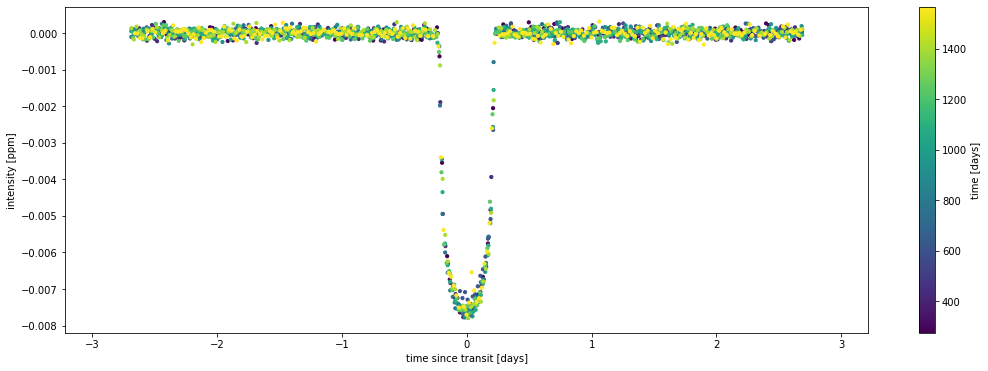

In [432]:
plot_phase_fold_lc(x, y, period, t0s, 50)

## Transit search

Now, let's use [the box least squares periodogram from AstroPy](http://docs.astropy.org/en/latest/timeseries/bls.html)
(Note: you'll need AstroPy v3.1 or more recent to use this feature) to estimate the period, phase, and depth of the transit.

Pull in Kipping KOI-3678 method marginalized data to test TTV predictions

2006


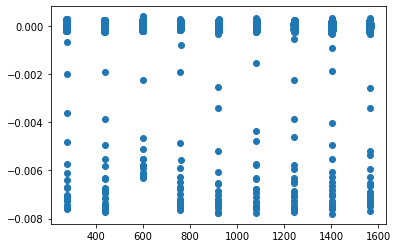

In [343]:
files = ['AVG_SAP.1.dat',
         'AVG_SAP.2.dat',
         'AVG_SAP.3.dat',
         'AVG_SAP.4.dat',
         'AVG_SAP.5.dat',
         'AVG_SAP.6.dat',
         'AVG_SAP.7.dat',
         'AVG_SAP.8.dat',
         'AVG_SAP.9.dat']

kipping_x = []
kipping_y = []
kipping_yerr = []
for file in files:
    data = pd.read_csv('./koi3678/kipping_method_marg/' + file, sep='\t')
    data.columns = ['x', 'y', 'yerr']
    
    data['x'] = data['x'] - 54833.
    data['y'] = data['y'] - 1.
    kipping_x = np.append(kipping_x, np.array(data['x']))
    kipping_y = np.append(kipping_y, np.array(data['y']))
    kipping_yerr = np.append(kipping_yerr, np.array(data['yerr']))
    
    
print(len(kipping_y))
plt.plot(kipping_x, kipping_y, 'o')

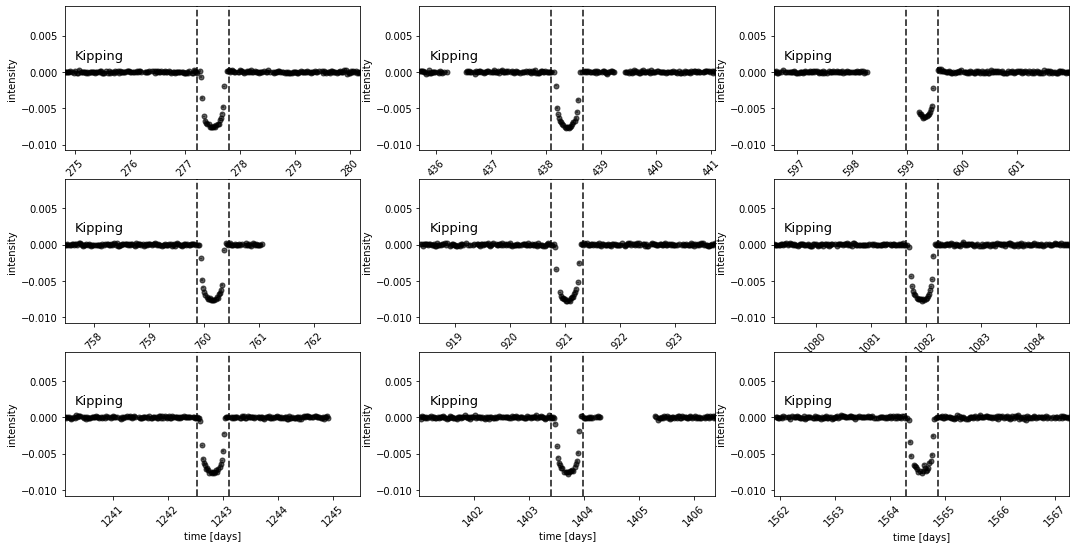

In [345]:
plot_detrended_lc(kipping_x, [kipping_y], kipping_yerr, ['Kipping'],
                  t0s, float(6*duration/(24.))/period, period,
                  ['k'], duration, depth = 0.009,
                  figname = './figures/koi3678_kipping_method_marg.pdf'
)

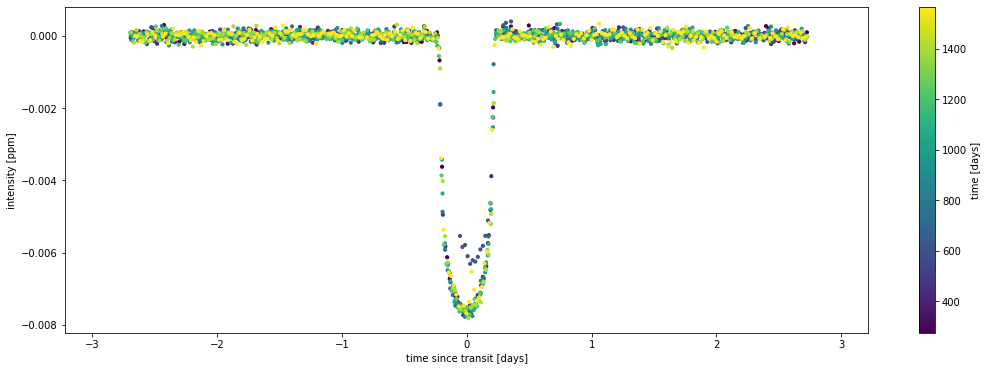

In [346]:
x, y, yerr = kipping_x, kipping_y, kipping_yerr
plot_phase_fold_lc(x, y, period, t0s, 50)

In [553]:
#add t0s for the 2 data gaps
t0s_no_gaps = [t0s[0]]
for ii in range(0,8):
    t0s_no_gaps.append(float(t0s_no_gaps[ii] + period))

        
print(t0s_no_gaps)  
print(t0s)
    

[144.52000000001863, 305.37000000001865, 466.2200000000187, 627.0700000000187, 787.9200000000187, 948.7700000000187, 1109.6200000000188, 1270.4700000000187, 1431.3200000000186]
[ 144.52  305.37  466.22  787.92 1109.62 1270.47 1431.32]


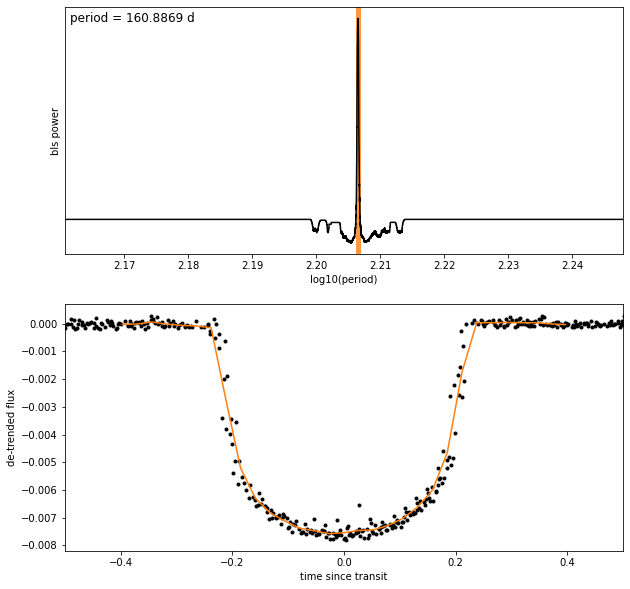

In [440]:

from astropy.timeseries import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(period[0]-.1*period[0]), np.log(period[0]+.1*period[0]), 50000))

bls = BoxLeastSquares(x, y)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(x, bls_period, 0.2, bls_t0)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate(
    "period = {0:.4f} d".format(bls_period),
    (0, 1),
    xycoords="axes fraction",
    xytext=(5, -5),
    textcoords="offset points",
    va="top",
    ha="left",
    fontsize=12,
)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold = (x - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold, y, ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y)
denom[num == 0] = 1.0
ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.5, 0.5)
ax.set_ylabel("de-trended flux")
_ = ax.set_xlabel("time since transit")

## The transit model in PyMC3

The transit model, initialization, and sampling are all nearly the same as the one in {ref}`joint`.

In [441]:
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt

x_plot = np.arange(np.min(x), np.max(x), 0.01)
with pm.Model() as model:

    #https://exoplanetarchive.ipac.caltech.edu/overview/koi-3678
    r_star = pm.Uniform("r_star", lower=.1, upper=100) 
    
    rp_over_rstar = pm.Uniform('rp_over_rstar', lower=0, upper=.1, testval=(np.sqrt(bls_depth)))
    
    
    #log_rho_star = pm.Uniform('log_rho_star', lower=10**(-3), upper=10**3)
    #rho_star = pm.Deterministic('rho_star', tt.exp(log_rho_star))
    
    
    
    
    b = pm.Uniform('b', lower=0, upper=1)
    
    u = xo.QuadLimbDark("u", testval=np.array([0.3, 0.2]))
    star = xo.LimbDarkLightCurve(u)
    

    # Now we have a parameter for each transit time for each planet:
    transit_times = []
    for i in range(1):
        transit_times.append(
            pm.Normal(
                "tts_{0}".format(i),
                mu=t0s,
                sd=10.0,
                shape=len(t0s),
            )
        )

    # Set up an orbit for the planets
    orbit = xo.orbits.TTVOrbit(b=b, transit_times=transit_times, ror=rp_over_rstar)

    # It will be useful later to track some parameters of the orbit
    pm.Deterministic("t0", orbit.t0)
    pm.Deterministic("period", orbit.period)
    for i in range(1):
        pm.Deterministic("ttvs_{0}".format(i), orbit.ttvs[i])
        
    # A jitter term describing excess white noise
    jitter = pm.Normal("jitter", mu=0., sd=0.1)
    
    yerr_model = pm.Deterministic('yerr_model', tt.sqrt(jitter**2. + yerr**2.))

    # The rest of this block follows the transit fitting tutorial
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(
        orbit=orbit, t=x, r=rp_over_rstar*r_star, texp=cadence
    )
    light_curve = pm.math.sum(light_curves, axis=-1)
    pm.Deterministic("light_curves", light_curves)
    
    #create lc for plot
    light_curves_plot = xo.LimbDarkLightCurve(u).get_light_curve(
        orbit=orbit, t=x_plot, r=rp_over_rstar*r_star, texp=cadence
    )
    light_curve_plot = pm.math.sum(light_curves_plot, axis=-1)
    pm.Deterministic("light_curves_plot", light_curves_plot)
    


    pm.Normal("obs", mu=light_curve, sd=yerr_model, observed=y)

    map_soln = model.test_point
    map_soln = pmx.optimize(start=map_soln, vars = rp_over_rstar)
    map_soln = pmx.optimize(start=map_soln)

optimizing logp for variables: [rp_over_rstar]


message: Optimization terminated successfully.
logp: -26427929380.10492 -> 592.4305527830863
optimizing logp for variables: [jitter, tts_0, u, b, rp_over_rstar, r_star]


message: Desired error not necessarily achieved due to precision loss.
logp: 592.4305527830863 -> 14632.282132766377


6.674299999999999e-08

In [365]:
from astropy.constants import G


G = G.cgs.value


import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt

x_plot = np.arange(np.min(x), np.max(x), 0.01)
with pm.Model() as model:

    #https://exoplanetarchive.ipac.caltech.edu/overview/koi-3678
    #r_star = pm.Uniform("r_star", lower=.1, upper=100) 
    
    rp_over_rstar = pm.Uniform('rp_over_rstar', lower=0, upper=.1, testval=(np.sqrt(bls_depth)))
    
    log_rho_star = pm.Uniform('log_rho_star', lower=-100, upper=10**10)
    rho_star = pm.Deterministic('rho_star', tt.exp(log_rho_star))
    
   
    
    #log_rho_star = pm.Uniform('log_rho_star', lower=10**(-3), upper=10**3)
    #rho_star = pm.Deterministic('rho_star', tt.exp(log_rho_star))
    
    
    
    
    b = pm.Uniform('b', lower=0, upper=2)
    
    u = xo.QuadLimbDark("u", testval=np.array([0.3, 0.2]))
    star = xo.LimbDarkLightCurve(u)
    

    # Now we have a parameter for each transit time for each planet:
    transit_times = []
    for i in range(1):
        transit_times.append(
            pm.Normal(
                "tts_{0}".format(i),
                mu=t0s,
                sd=10.0,
                shape=len(t0s),
            )
        )

    # Set up an orbit for the planets
    orbit = xo.orbits.TTVOrbit(b=b, transit_times=transit_times, ror=rp_over_rstar, rho_star=rho_star)

    # It will be useful later to track some parameters of the orbit
    pm.Deterministic("t0", orbit.t0)
    P = pm.Deterministic("period", orbit.period)
    a = pm.Deterministic("a", orbit.a)
    
    r_star = pm.Deterministic('r_star', (a / ( (rho_star * G * P**2.) / (3 * np.pi) )**(1/3)))

    for i in range(1):
        pm.Deterministic("ttvs_{0}".format(i), orbit.ttvs[i])
        
    # A jitter term describing excess white noise
    jitter = pm.Normal("jitter", mu=0., sd=0.1)
    
    yerr_model = pm.Deterministic('yerr_model', tt.sqrt(jitter**2. + yerr**2.))

    # The rest of this block follows the transit fitting tutorial
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(
        orbit=orbit, t=x, r=rp_over_rstar*r_star, texp=cadence
    )
    light_curve = pm.math.sum(light_curves, axis=-1)
    pm.Deterministic("light_curves", light_curves)
    
    #create lc for plot
    light_curves_plot = xo.LimbDarkLightCurve(u).get_light_curve(
        orbit=orbit, t=x_plot, r=rp_over_rstar*r_star, texp=cadence
    )
    light_curve_plot = pm.math.sum(light_curves_plot, axis=-1)
    pm.Deterministic("light_curves_plot", light_curves_plot)
    


    pm.Normal("obs", mu=light_curve, sd=yerr_model, observed=y)

    map_soln = model.test_point
    map_soln = pmx.optimize(start=map_soln, vars = rp_over_rstar)
    map_soln = pmx.optimize(start=map_soln)

optimizing logp for variables: [rp_over_rstar]


message: NaN result encountered.
logp: -2811.7611912754883 -> -2811.7611912754883
optimizing logp for variables: [jitter, tts_0, u, b, log_rho_star, rp_over_rstar]


message: NaN result encountered.
logp: -2811.7611912754883 -> -2811.7611912754883


In [370]:
print(map_soln['rp_over_rstar'])

0.0686198003902619


In [347]:

import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt

x_plot = np.arange(np.min(x), np.max(x), 0.01)
with pm.Model() as model:

    #https://exoplanetarchive.ipac.caltech.edu/overview/koi-3678
    
    rp_over_rstar = pm.Uniform('rp_over_rstar', lower=0, upper=1, testval=(np.sqrt(bls_depth)))
    
    
    #log_rho_star = pm.Uniform('log_rho_star', lower=-10, upper=10**10)
    rho_star = pm.Uniform('rho_star', lower=10**(-3), upper=10**3)#tt.exp(log_rho_star))
    
    
    
    #b = xo.ImpactParameter(
    #    "b", ror=rp_over_rstar, shape=1, testval=0.5 * np.random.rand(1))
    
    b = pm.Uniform('b', lower=0, upper=2)
    
    u = xo.QuadLimbDark("u", testval=np.array([0.3, 0.2]))
    

    # Now we have a parameter for each transit time for each planet:
    transit_times = []
    for i in range(1):
        transit_times.append(
            pm.Normal(
                "tts_{0}".format(i),
                mu=t0s,
                sd=10.0,
                shape=len(t0s),
            )
        )

    # Set up an orbit for the planets
    orbit = xo.orbits.TTVOrbit(b=b, transit_times=transit_times, ror = rp_over_rstar, rho_star = rho_star)
    
    #test output here!

    # It will be useful later to track some parameters of the orbit
    pm.Deterministic("t0", orbit.t0)
    P = pm.Deterministic("period", orbit.period)
    a = pm.Deterministic("a", orbit.a)
    for i in range(1):
        pm.Deterministic("ttvs_{0}".format(i), orbit.ttvs[i])
        
    # A jitter term describing excess white noise
    jitter = pm.Normal("jitter", mu=0., sd=0.1)
    
    yerr_model = pm.Deterministic('yerr_model', tt.sqrt(jitter**2. + yerr**2.))
    
    r_star = pm.Deterministic('r_star', (a / ( (rho_star * G * P**2.) / (3 * np.pi) )**(1/3)))
    print(r_star)
    
    # The rest of this block follows the transit fitting tutorial
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(
        orbit=orbit, t=x, r=rp_over_rstar*r_star, texp=cadence
    )
    light_curve = pm.math.sum(light_curves, axis=-1)
    pm.Deterministic("light_curves", light_curves)
    
    #create lc for plot
    light_curves_plot = xo.LimbDarkLightCurve(u).get_light_curve(
        orbit=orbit, t=x_plot, r=rp_over_rstar*r_star, texp=cadence
    )
    light_curve_plot = pm.math.sum(light_curves_plot, axis=-1)
    pm.Deterministic("light_curves_plot", light_curves_plot)
    


    pm.Normal("obs", mu=light_curve, sd=yerr_model, observed=y)

    map_soln = model.test_point
    map_soln = pmx.optimize(start=map_soln, vars = rho_star)
    map_soln = pmx.optimize(start=map_soln)

r_star ~ Deterministic


optimizing logp for variables: [rho_star]


message: Optimization terminated successfully.
logp: -2812.975870998228 -> -2812.975870998228
optimizing logp for variables: [jitter, tts_0, u, b, rho_star, rp_over_rstar]


message: Optimization terminated successfully.
logp: -2812.975870998228 -> -2811.1498680419086


[19543.80683948]


Here's how we plot the initial light curve model:

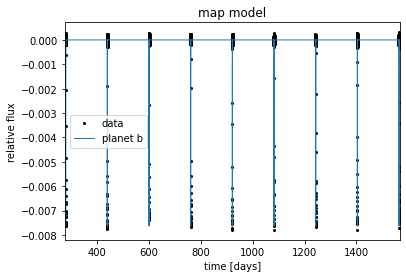

In [442]:
plt.plot(x, y, ".k", ms=4, label="data")
for i, l in enumerate("b"):
    plt.plot(
        x_plot, map_soln["light_curves_plot"][:, i], lw=1, label="planet {0}".format(l)
    )
plt.xlim(x.min(), x.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")

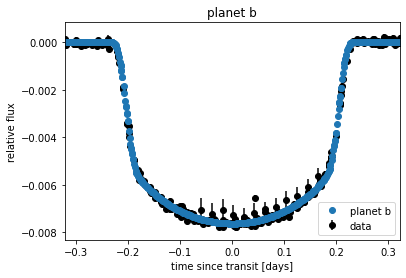

In [443]:
with model:
    t_warp = pmx.eval_in_model(orbit._warp_times(x), map_soln)
    t_warp_model = pmx.eval_in_model(orbit._warp_times(x_plot), map_soln)

for n, letter in enumerate("b"):
    plt.figure()

    p = map_soln["period"][n]

    # NOTE: 't0' has already been subtracted!
    x_fold = (t_warp[:, n] + 0.5 * p) % p - 0.5 * p
    x_fold_model = (t_warp_model[:, n] + 0.5 * p) % p - 0.5 * p
    plt.errorbar(
        x_fold, y, yerr=yerr, fmt="ok", label="data", zorder=-1000
    )
    plt.plot(
        x_fold_model, map_soln["light_curves_plot"][:, i], 'o', label="planet {0}".format(l)
    )

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.002 * p, 0.002 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter))


In [581]:
print(p)

160.85606070493006


In [444]:
with model:
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        start=map_soln,
        cores=2,
        chains=2,
        target_accept=.95,
        return_inferencedata=True,
    )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [jitter, tts_0, u, b, rp_over_rstar, r_star]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2307 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [445]:
import arviz as az

az.summary(trace, var_names=["u", "rp_over_rstar", "b", "tts_0", "ttvs_0","period"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
u[0],0.560,0.019,0.521,0.595,0.001,0.000,1128.0,920.0,1.00
u[1],-0.140,0.031,-0.192,-0.076,0.001,0.001,1130.0,1052.0,1.00
rp_over_rstar,0.016,0.016,0.001,0.050,0.001,0.001,70.0,88.0,1.02
b,0.010,0.008,0.000,0.024,0.000,0.000,847.0,587.0,1.00
tts_0[0],277.506,0.001,277.505,277.507,0.000,0.000,1056.0,1230.0,1.00
tts_0[1],438.387,0.000,438.386,438.388,0.000,0.000,1106.0,1127.0,1.00
tts_0[2],599.279,0.002,599.276,599.282,0.000,0.000,1107.0,1345.0,1.00
tts_0[3],760.154,0.001,760.152,760.155,0.000,0.000,1308.0,1197.0,1.00
tts_0[4],921.046,0.000,921.045,921.046,0.000,0.000,1104.0,1329.0,1.00
tts_0[5],1081.930,0.000,1081.929,1081.931,0.000,0.000,1043.0,1440.0,1.00


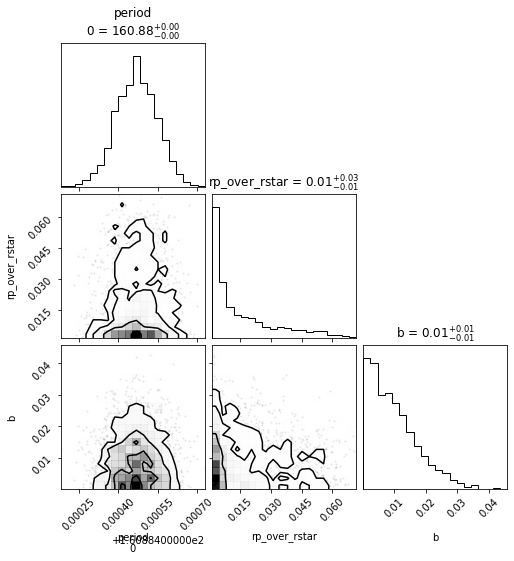

In [446]:
import corner

names = ["period", "rp_over_rstar", "b"]


_ = corner.corner(
    trace,
    var_names=names,
    show_titles=True
)

In [447]:
tts_median = []
ttvs_median = []
P_median = np.quantile(trace.posterior["period"].values, 0.5)
t0_median = np.median(trace.posterior["t0"].values)

tts_err = []
ttvs_err = []
for ii in range(0, len(t0s)):
        tts = np.median(trace.posterior["tts_0"].values[:, :, ii])
        ttvs = 24.*60.*np.median(trace.posterior["ttvs_0"].values[:, :, ii])

        tts_median.append(tts)
        ttvs_median.append(ttvs)


        tts_quantile = [np.quantile(trace.posterior["tts_0"].values[:, :, ii], 0.16),
                        np.quantile(trace.posterior["tts_0"].values[:, :, ii], 0.84)]
        ttvs_quantile = [24.*60.*np.quantile(trace.posterior["ttvs_0"].values[:, :, ii], 0.16),
                         24.*60.*np.quantile(trace.posterior["ttvs_0"].values[:, :, ii], 0.84)]

        tts_err.append(np.array([
            tts - tts_quantile[0],
            tts_quantile[1] - tts
        ]))
        ttvs_err.append(np.array([
            ttvs - ttvs_quantile[0],
            ttvs_quantile[1] - ttvs
        ]))
    

tts_err = np.array(tts_err).T
ttvs_err = np.array(ttvs_err).T



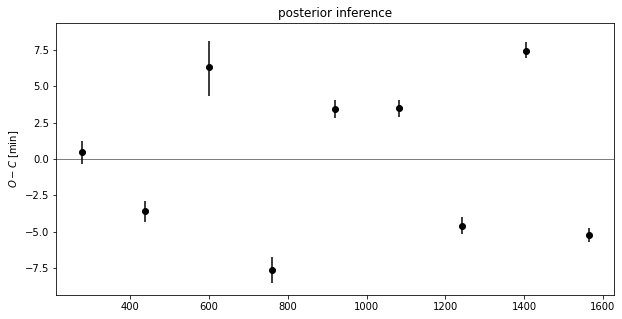

In [449]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

fig, ax1 = plt.subplots(1, 1, figsize=(10, 5), sharex=True)

ax1.errorbar(tts_median, ttvs_median, xerr = tts_err, yerr = ttvs_err, ls = '', marker = 'o', color = 'k')
ax1.axhline(0, color="k", lw=0.5)
ax1.set_ylim(np.max(np.abs(ax1.get_ylim())) * np.array([-1, 1]))

ax1.set_ylabel("$O-C$ [min]")


_ = ax1.set_title("posterior inference")

plt.savefig('./figures/koi3678_ttvs_april8.pdf')

In [596]:
print(ttvs_median)

[149.21071480792762, 23.145691015565717, -9.305210175880347, -92.87944543782942, -13.934119499463122, 24.242319610202685, 191.63633922138615]


In [ ]:
0       54977.594371560495      0.017592150805  0.020459585241  111.607507098   25.33269716     29.461802747
1       55138.367370618398      0.020077416193  0.025136732213  -3.931986896    28.911479318    36.196894386
2       55299.192146263125      0.014137282797  0.016450608866  -44.913195863   20.357687227    23.688876767
4       55620.852626129366      0.019328311631  0.028709204394  -111.138463223  27.832768749    41.341254328
6       55942.602966540297      0.012769116016  0.01583637896   -47.964546232   18.387527063    22.804385702
7       56103.481782812243      0.023414547595  0.022504775672  -11.127252002   33.716948537    32.406876968
8       56264.442352146292      0.023647533588  0.017454851997  143.434451655   34.052448366    25.134986876


[144.4962449722031, 305.34860730568914, 466.2009696391752, 787.9056943061473, 1109.6104189731193, 1270.4627813066054, 1431.3151436400915]

kipping
141.30228714083387
27.01917030093682
-12.705661517038607
-76.41817456453282
-10.73150326465111
27.362168113177177
183.18024892385438


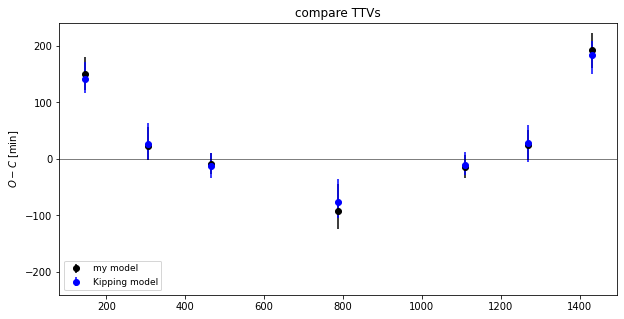

In [612]:
#koi-4307
time_model = []
for ii in range(0,9):
    time_model.append(t0_median+(P_median*ii))

del time_model[3]
del time_model[4]
print(time_model)
    
x_kipping = np.array([54977.594371560495, 55138.367370618398, 55299.192146263125,
                      55620.852626129366, 55942.602966540297, 56103.481782812243, 
                      56264.442352146292])
x_kipping -= 54833 

    
yerr_kipping = np.array([
    [0.017592150805, 0.020459585241],
    [0.020077416193, 0.025136732213],
    [0.014137282797, 0.016450608866],
    [0.019328311631, 0.028709204394],
    [0.012769116016, 0.01583637896],
    [0.023414547595, 0.022504775672],
    [0.023647533588, 0.017454851997]]).T
yerr_kipping = 24.*60.*yerr_kipping

print('')
print("kipping")
y_kipping = []
epoch = 0
for time in x_kipping:
    y_kipping.append(24. * 60. * (time-time_model[epoch]))
    print(24. * 60. * (time-time_model[epoch]))
    epoch+=1
    
    
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5), sharex=True)


ax1.errorbar(tts_median, ttvs_median, yerr = 24.*60.*tts_err, ls = '', marker = 'o', color = 'k', label = "my model")
ax1.errorbar(x_kipping, y_kipping, yerr = yerr_kipping, ls = '', marker = 'o', color = 'b', label = "Kipping model")

ax1.axhline(0, color="k", lw=0.5)
ax1.set_ylim(np.max(np.abs(ax1.get_ylim())) * np.array([-1, 1]))

ax1.set_ylabel("$O-C$ [min]")

ax1.legend(fontsize = 9, loc=3)
_ = ax1.set_title("compare TTVs") 

plt.savefig('./figures/koi4307_ttvs_April1_all.pdf')

[277.50542552367483, 438.3898940179325, 599.2743625121901, 760.1588310064478, 921.0432995007054, 1081.927767994963, 1242.8122364892206, 1403.6967049834784, 1564.581173477736]

holczer
399612.64608
631286.50752
1094634.2304
1326308.09184
1557981.95328
1789655.8147200001
2021329.67616
2253003.5376

kipping
399608.10310448636
631278.3803430072
862954.7995986894
1094622.6268399274
1326305.9003242257
1557978.360873477
1789644.9491413299
2021330.6662629533
2252991.7629685462


NameError: name 'kipping_tts_median' is not defined

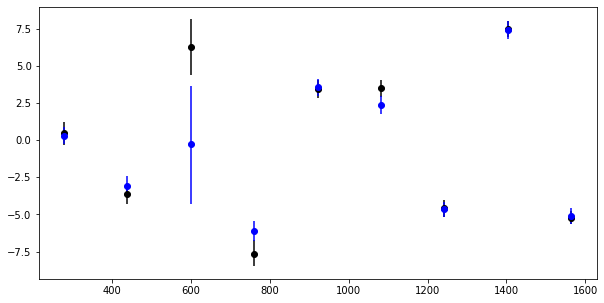

In [450]:
#koi-3678

t_offset = 2454900 - 2454833 

time_model = []
for ii in range(0,9):
    time_model.append(t0_median+(P_median*ii))
    #print(24. * 60. * (tts_median[ii]-time_model[ii]))
    #print(ttvs_median[ii])
print(time_model)
    
'''
holczer Vizier data
N	T_i[days]	err[min]
0	210.508782	6e-01
1	371.393408	6e-01
3	693.162660	6e-01
4	854.047286	6e-01
5	1014.931912	6e-01
6	1175.816538	6e-01
7	1336.701164	6e-01
8	1497.585790	6e-01

Period
160.88462604


my period
160.8843361711165

'''    
    
print('')
print("holczer")
x_holczer = np.array([210.508782, 371.393408, 693.162660, 854.047286, 1014.931912, 1175.816538, 1336.701164, 1497.585790])
x_holczer += t_offset
y_holczer = []
epoch = 0
for time in x_holczer:
    if epoch == 2:
        epoch += 1
        
    #print(24. * 60. * (time-time_model[epoch]))
    y_holczer.append(24. * 60. * (time-time_model[epoch]))
    epoch+=1
    

y_holczer = np.array([3.6400, -3.6800, -6.0300, 4.5100, 3.0200, -4.2100, 8.1400, -5.3800])
yerr_holczer = np.array([6e-01, 6e-01, 6e-01, 6e-01, 6e-01, 6e-01, 6e-01, 6e-01])

x_kipping = np.array([55110.505627155893, 55271.387764127088, 55432.274166387979,
                      55593.154601972172, 55754.045764114046, 55914.929417273248, 
                      56075.808992459257, 56236.701851571495, 56397.577613172602])
x_kipping -= 54833 

for ii in range(0, len(x_holczer)):
    print(24.*60.*x_holczer[ii])
    
yerr_kipping = np.array([
    [0.000402962774, 0.000399917204],
    [0.000440256757, 0.000441709722],
    [0.002814652733, 0.002745562269],
    [0.00046894051, 0.000469475679],
    [0.000409040716, 0.000403825223],
    [0.000424959595, 0.000417035772],
    [0.000362309329, 0.000367076056],
    [0.000423798963, 0.000430076718],
    [0.000367674438, 0.000366104934]]).T
yerr_kipping = 24.*60.*yerr_kipping

print('')
print("kipping")
y_kipping = []
epoch = 0
for time in x_kipping:
    y_kipping.append(24. * 60. * (time-time_model[epoch]))
    #print(24. * 60. * (time-time_model[epoch]))
    epoch+=1
    
    

for ii in range(0, len(x_kipping)):
    print(24.*60.*x_kipping[ii])
    
'''    
# for TTVs comparison, read in times and then subtract out ephemeris information
0	55110.505627155893	0.000402962774	0.000399917204	1.087096278	0.580266395	0.575880774
1	55271.387764127088	0.000440256757	0.000441709722	-2.265761699	0.633969731	0.636062
2	55432.274166387979	0.002814652733	0.002745562269	0.523397485	4.053099936	3.953609668
3	55593.154601972172	0.00046894051	0.000469475679	-5.279457775	0.675274335	0.676044978
4	55754.045764114046	0.000409040716	0.000403825223	4.363930026	0.589018632	0.581508321
5	55914.929417273248	0.000424959595	0.000417035772	3.194382779	0.611941817	0.600531511
6	56075.808992459257	0.000362309329	0.000367076056	-3.847445866	0.521725434	0.528589521
7	56236.701851571495	0.000423798963	0.000430076718	8.23957926	0.610270507	0.619310473
8	56397.577613172602	0.000367674438	0.000366104934	-4.293811645	0.529451191	0.527191105
'''



fig, ax1 = plt.subplots(1, 1, figsize=(10, 5), sharex=True)


ax1.errorbar(tts_median, ttvs_median, yerr = ttvs_err, ls = '', marker = 'o', color = 'k', label = "my model")
#ax1.errorbar(x_holczer, y_holczer, yerr = yerr_holczer, ls = '', marker = 'o', color = 'r', label = "Holczer et al. 2016")
ax1.errorbar(x_kipping, y_kipping, yerr = yerr_kipping, ls = '', marker = 'o', color = 'b', label = "Kipping model")
ax1.errorbar(kipping_tts_median, kipping_ttvs_median, xerr = kipping_tts_err, 
             yerr = kipping_ttvs_err, ls = '', marker = 'o', color = 'g', label = "Kipping LCs + my model")

ax1.axhline(0, color="k", lw=0.5)
ax1.set_ylim(np.max(np.abs(ax1.get_ylim())) * np.array([-1, 1]))

ax1.set_ylabel("$O-C$ [min]")

ax1.legend(fontsize = 9, loc=3)
_ = ax1.set_title("compare TTVs") 

#plt.savefig('./figures/koi3678_ttvs_March29_all.pdf')